In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import json
from IPython.display import display
from scipy.stats import chi2_contingency

In [2]:
df_cleaned=pd.read_csv('./complaints.csv')
df_cleaned

/var/folders/zr/gzwryy5s75s63h4qbx6269tc0000gn/T/ipykernel_4414/1931912523.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cleaned=pd.read_csv('./complaints.csv')


Date received                                            Product  \
0          2024-06-29  Credit reporting or other personal consumer re...   
1          2024-06-29  Credit reporting or other personal consumer re...   
2          2024-06-29  Credit reporting or other personal consumer re...   
3          2024-06-29  Credit reporting or other personal consumer re...   
4          2024-06-29  Credit reporting or other personal consumer re...   
...               ...                                                ...   
5540170    2013-06-04                                        Credit card   
5540171    2011-12-30                                        Credit card   
5540172    2013-04-23                                           Mortgage   
5540173    2013-03-05                                           Mortgage   
5540174    2012-05-01                                        Credit card   

                         Sub-product  \
0                   Credit reporting   
1                   Credit reporting   
2                   Credit reporting   
3                   Credit reporting   
4                   Credit reporting   
...                              ...   
5540170                          NaN   
5540171                          NaN   
5540172               Other mortgage   
5540173  Conventional fixed mortgage   
5540174                          NaN   

                                            Issue  \
0                     Improper use of your report   
1                     Improper use of your report   
2                     Improper use of your report   
3            Incorrect information on your report   
4            Incorrect information on your report   
...                                           ...   
5540170                          Billing disputes   
5540171     Identity theft / Fraud / Embezzlement   
5540172  Loan servicing, payments, escrow account   
5540173  Application, originator, mortgage broker   
5540174                                   Privacy   

                                                 Sub-issue  \
0            Reporting company used your report improperly   
1            Reporting company used your report improperly   
2        Credit inquiries on your report that you don't...   
3                      Information belongs to someone else   
4                      Information belongs to someone else   
...                                                    ...   
5540170                                                NaN   
5540171                                                NaN   
5540172                                                NaN   
5540173                                                NaN   
5540174                                                NaN   

        Consumer complaint narrative Company public response  \
0                                NaN                     NaN   
1                                NaN                     NaN   
2                                NaN                     NaN   
3                                NaN                     NaN   
4                                NaN                     NaN   
...                              ...                     ...   
5540170                          NaN                     NaN   
5540171                          NaN                     NaN   
5540172                          NaN                     NaN   
5540173                          NaN                     NaN   
5540174                          NaN                     NaN   

                                       Company State ZIP code Tags  \
0                                EQUIFAX, INC.    TX    77356  NaN   
1                                EQUIFAX, INC.    ID    838XX  NaN   
2                                EQUIFAX, INC.    CA    94806  NaN   
3                                EQUIFAX, INC.    GA    30260  NaN   
4                                EQUIFAX, INC.    AL    35404  NaN   
...                                        

In [3]:
df_cleaned['Year'] = pd.to_datetime(df_cleaned['Date received']).dt.year

df_cleaned['Product'] = df_cleaned['Product'].replace({
    'Credit reporting or other personal consumer reports': 'Credit reporting, credit repair services, or other personal consumer reports',
    'Credit reporting': 'Credit reporting, credit repair services, or other personal consumer reports'
})
complaints_per_company = df_cleaned.groupby('Company').size().reset_index(name='Number of Complaints')



7281
Top 10 companies:
                                     Company  Number of Complaints
2278                           EQUIFAX, INC.               1179093
6480  TRANSUNION INTERMEDIATE HOLDINGS, INC.               1101539
2455     Experian Information Solutions Inc.               1008453
817    BANK OF AMERICA, NATIONAL ASSOCIATION                142144
7032                   WELLS FARGO & COMPANY                130548
3555                    JPMORGAN CHASE & CO.                121823
1141       CAPITAL ONE FINANCIAL CORPORATION                101968
1228                          CITIBANK, N.A.                 96308
5973                     SYNCHRONY FINANCIAL                 52523
4731                 Navient Solutions, LLC.                 40376
Top 10 companies with 'Other':
                                   Company  Number of Complaints
0                            EQUIFAX, INC.               1179093
1   TRANSUNION INTERMEDIATE HOLDINGS, INC.               1101539
2      Experia

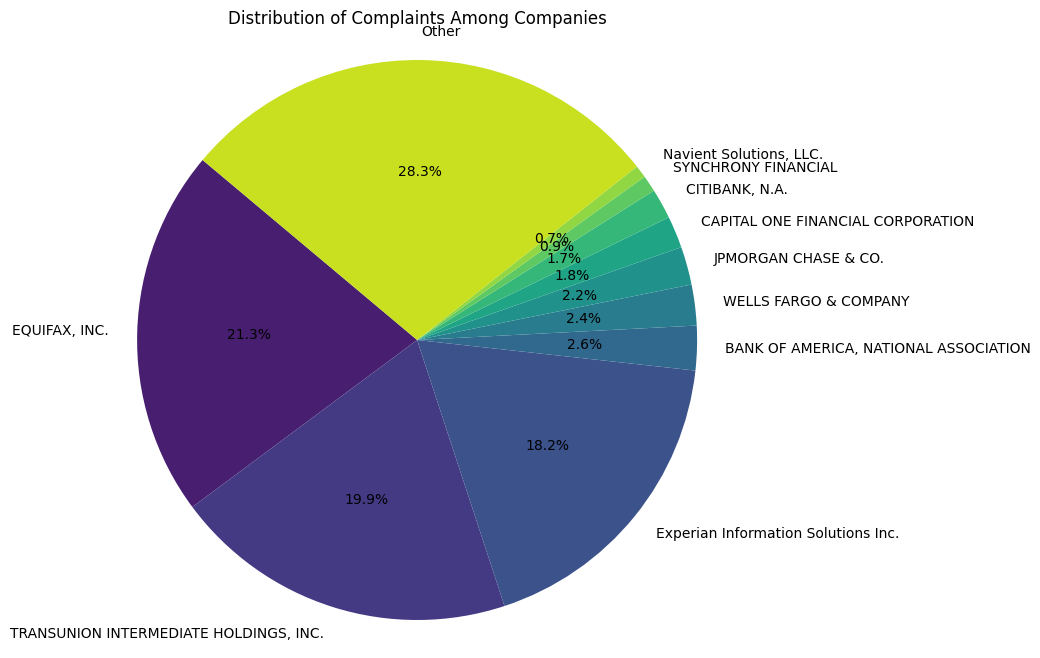

In [4]:
print(complaints_per_company.shape[0])
top_10_companies = complaints_per_company.sort_values(by='Number of Complaints', ascending=False).head(10)
print("Top 10 companies:")
print(top_10_companies)

other_complaints = complaints_per_company.sort_values(by='Number of Complaints', ascending=False).iloc[10:]['Number of Complaints'].sum()

other_df = pd.DataFrame([{'Company': 'Other', 'Number of Complaints': other_complaints}])

top_10_companies = pd.concat([top_10_companies, other_df], ignore_index=True)
print("Top 10 companies with 'Other':")
print(top_10_companies)


plt.figure(figsize=(10, 8))
plt.pie(top_10_companies['Number of Complaints'], labels=top_10_companies['Company'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(top_10_companies)))
plt.title('Distribution of Complaints Among Companies')
plt.axis('equal')
plt.show()

Top 3 companies: ['EQUIFAX, INC.', 'TRANSUNION INTERMEDIATE HOLDINGS, INC.', 'Experian Information Solutions Inc.']
         Company  Year  Number of Complaints
0  EQUIFAX, INC.  2012                   622
1  EQUIFAX, INC.  2013                  4776
2  EQUIFAX, INC.  2014                  9963
3  EQUIFAX, INC.  2015                 12003
4  EQUIFAX, INC.  2016                 15973


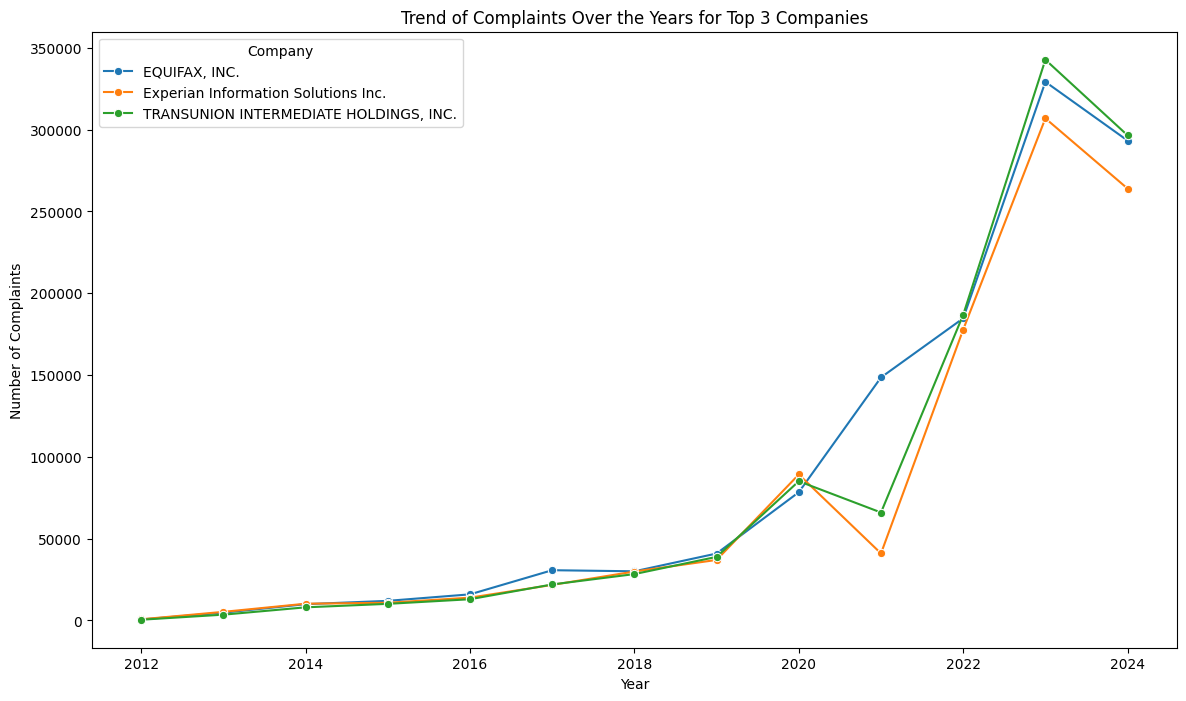

In [5]:

top_3_companies = complaints_per_company.sort_values(by='Number of Complaints', ascending=False).head(3)['Company'].tolist()
print(f"Top 3 companies: {top_3_companies}")


top_3_data = df_cleaned[df_cleaned['Company'].isin(top_3_companies)]
complaints_per_year = top_3_data.groupby(['Company', 'Year']).size().reset_index(name='Number of Complaints')
print(complaints_per_year.head())


plt.figure(figsize=(14, 8))
sns.lineplot(x='Year', y='Number of Complaints', hue='Company', data=complaints_per_year, marker='o')
plt.title('Trend of Complaints Over the Years for Top 3 Companies')
plt.xlabel('Year')
plt.ylabel('Number of Complaints')
plt.legend(title='Company')
plt.show()


<Figure size 1000x600 with 0 Axes>

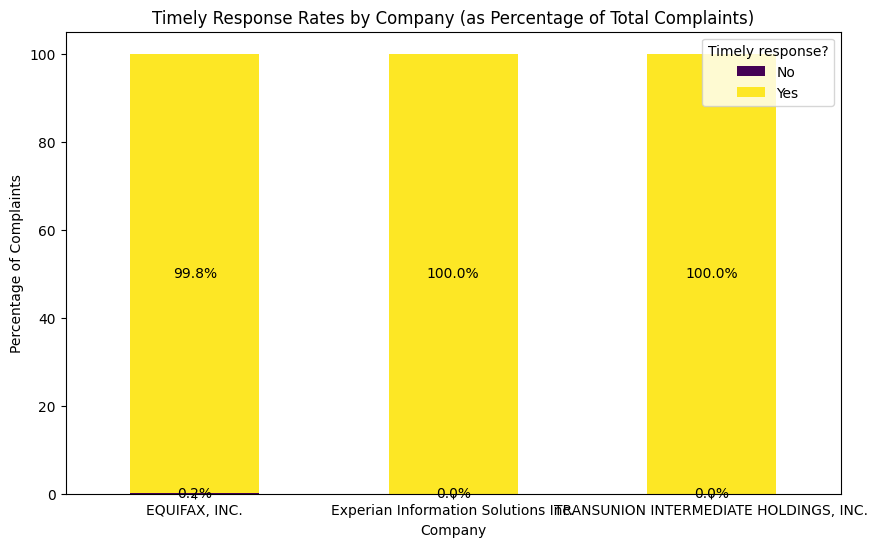

In [15]:
response_rates = top_3_data.groupby(['Company', 'Timely response?']).size().unstack().fillna(0)


response_rates_percentage = response_rates.div(response_rates.sum(axis=1), axis=0) * 100


plt.figure(figsize=(10, 6))
ax = response_rates_percentage.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')


for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.text(x + width/2, y + height/2, f'{height:.1f}%', ha='center', va='center')

plt.title('Timely Response Rates by Company (as Percentage of Total Complaints)')
plt.xlabel('Company')
plt.ylabel('Percentage of Complaints')
plt.xticks(rotation=0) 
plt.show()

/var/folders/zr/gzwryy5s75s63h4qbx6269tc0000gn/T/ipykernel_4414/2941373972.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_3_data['Date received'] = pd.to_datetime(top_3_data['Date received'])
/var/folders/zr/gzwryy5s75s63h4qbx6269tc0000gn/T/ipykernel_4414/2941373972.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_3_data['Date sent to company'] = pd.to_datetime(top_3_data['Date sent to company'])
/var/folders/zr/gzwryy5s75s63h4qbx6269tc0000gn/T/ipykernel_4414/2941373972.py:6: SettingWithCopy

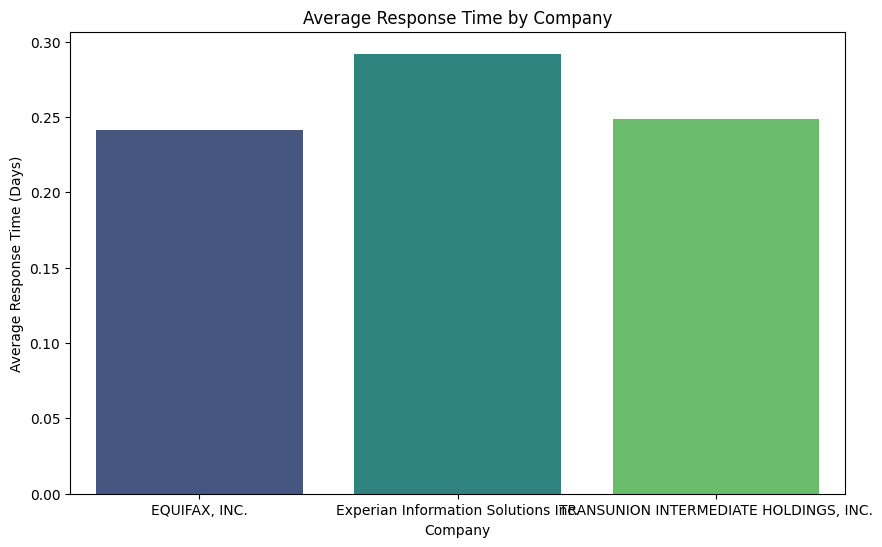

In [7]:



top_3_data['Date received'] = pd.to_datetime(top_3_data['Date received'])
top_3_data['Date sent to company'] = pd.to_datetime(top_3_data['Date sent to company'])


top_3_data['Response Time'] = (top_3_data['Date sent to company'] - top_3_data['Date received']).dt.days


avg_response_time = top_3_data.groupby('Company')['Response Time'].mean().reset_index()


plt.figure(figsize=(10, 6))
sns.barplot(x='Company', y='Response Time', data=avg_response_time, palette='viridis')
plt.title('Average Response Time by Company')
plt.ylabel('Average Response Time (Days)')
plt.show()


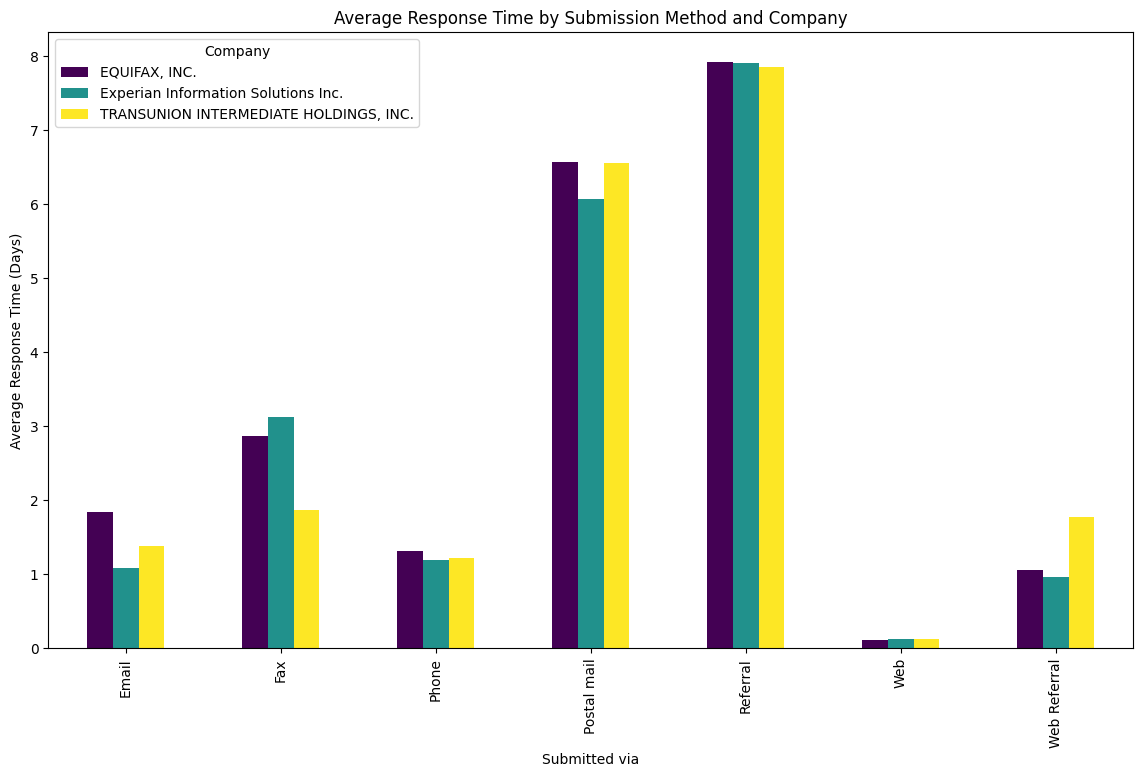

In [10]:

submission_response_time = top_3_data.groupby(['Company', 'Submitted via'])['Response Time'].mean().unstack()


submission_response_time.T.plot(kind='bar', figsize=(14, 8), colormap='viridis')
plt.title('Average Response Time by Submission Method and Company')
plt.ylabel('Average Response Time (Days)')
plt.show()


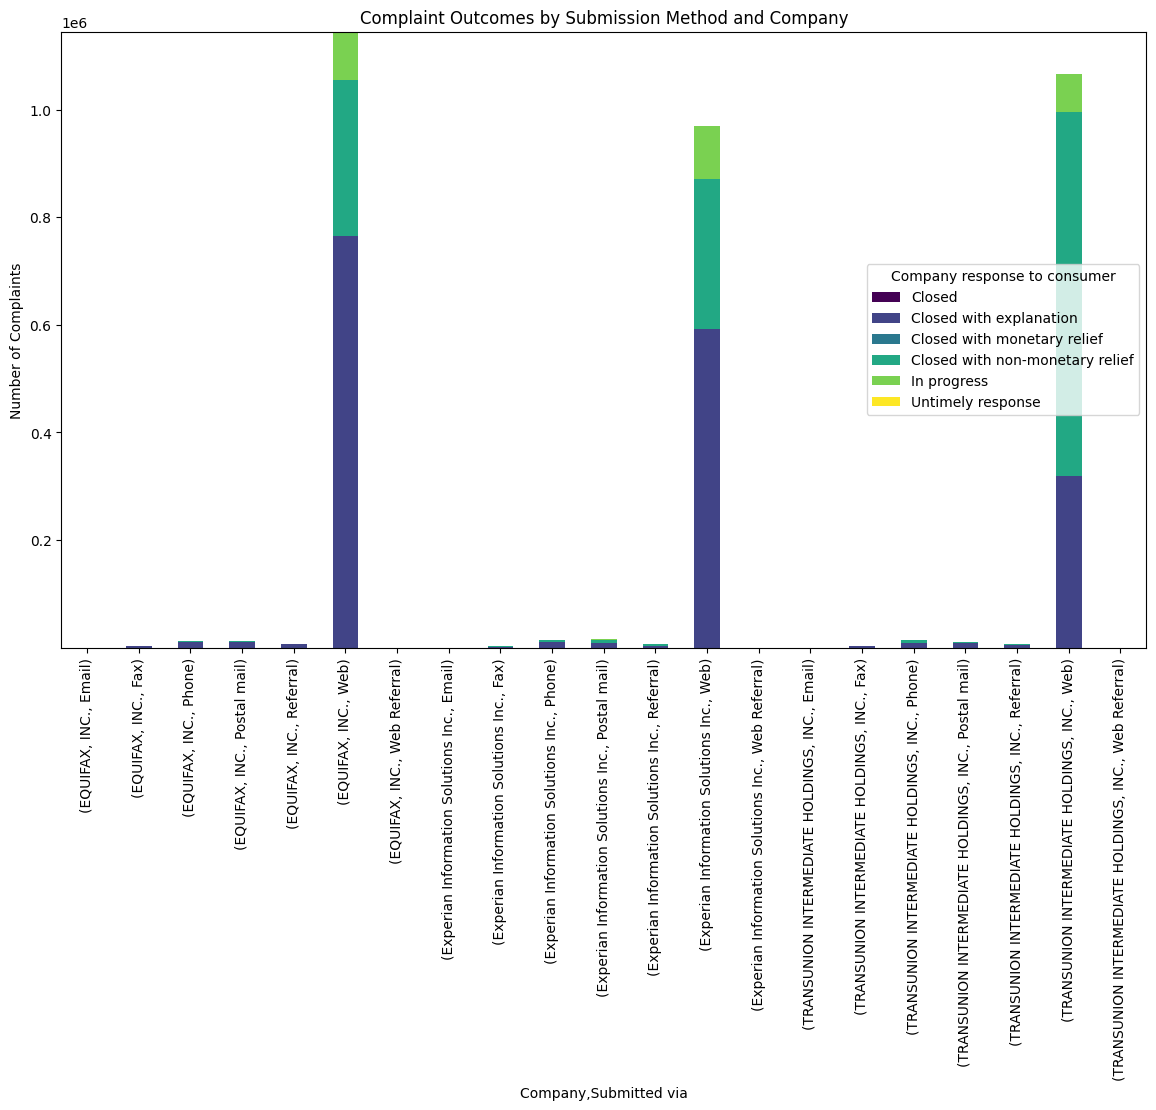

In [11]:

submission_outcome_crosstab = pd.crosstab([top_3_data['Company'], top_3_data['Submitted via']], top_3_data['Company response to consumer'])


submission_outcome_crosstab.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='viridis')
plt.title('Complaint Outcomes by Submission Method and Company')
plt.ylabel('Number of Complaints')
plt.show()


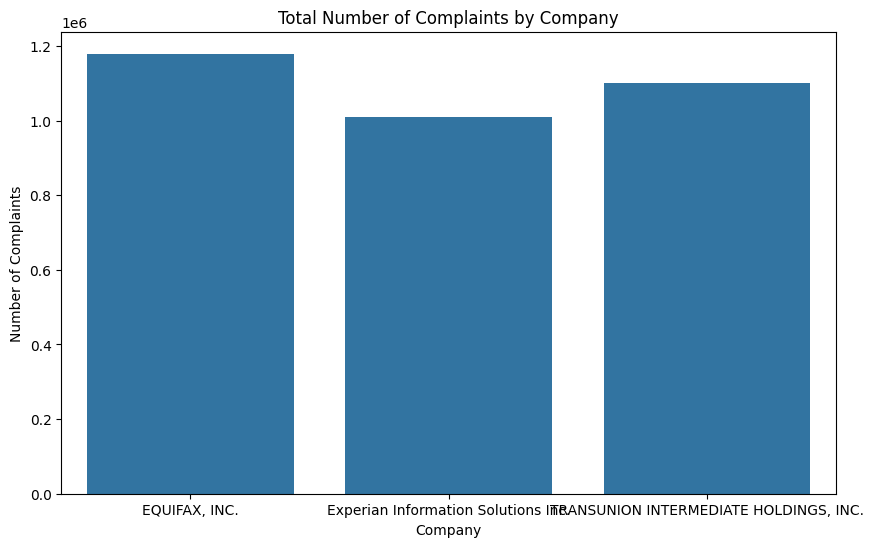

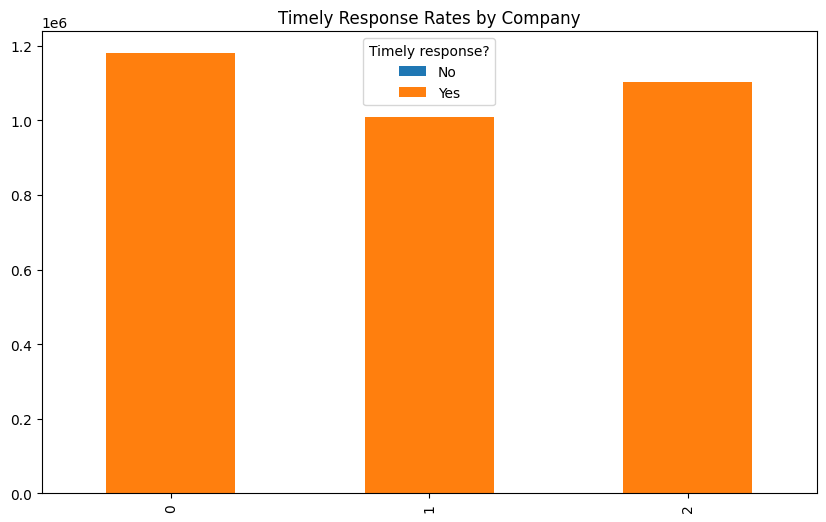

Chi-Square Test: p-value = 0.0


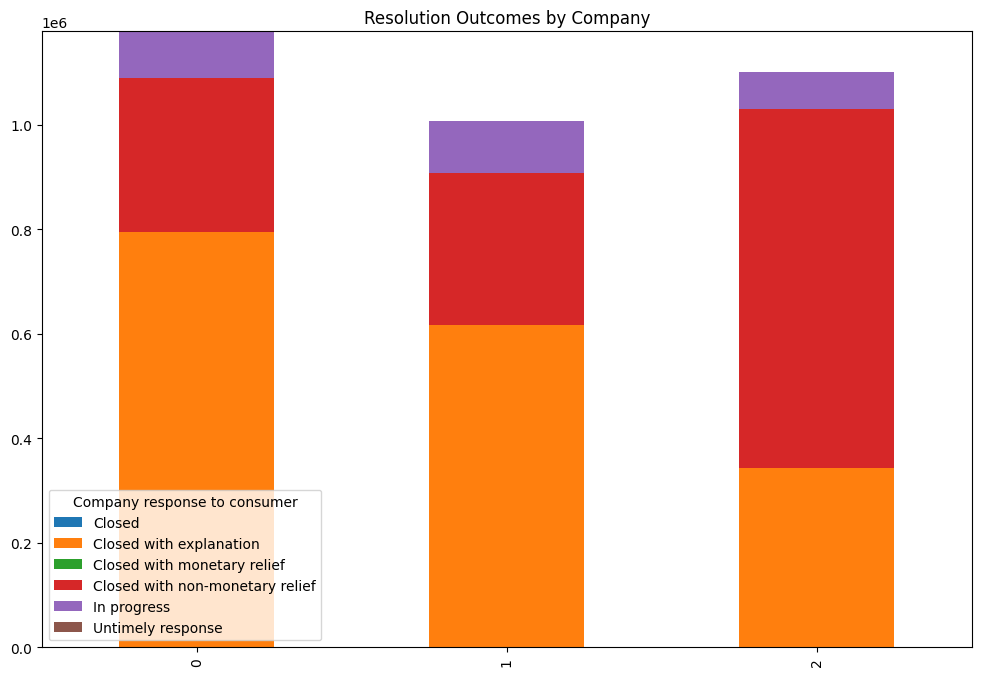

Chi-Square Test for Resolution Outcomes: p-value = 0.0


In [13]:



complaints_summary = top_3_data.groupby('Company').size().reset_index(name='Number of Complaints')
plt.figure(figsize=(10, 6))
sns.barplot(x='Company', y='Number of Complaints', data=complaints_summary)
plt.title('Total Number of Complaints by Company')
plt.show()


response_rates = top_3_data.groupby(['Company', 'Timely response?']).size().unstack().reset_index()
response_rates.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Timely Response Rates by Company')
plt.show()


contingency_table = pd.crosstab(top_3_data['Company'], top_3_data['Timely response?'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square Test: p-value = {p}")


resolution_outcomes = top_3_data.groupby(['Company', 'Company response to consumer']).size().unstack().reset_index()
resolution_outcomes.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Resolution Outcomes by Company')
plt.show()


contingency_table_res = pd.crosstab(top_3_data['Company'], top_3_data['Company response to consumer'])
chi2_res, p_res, dof_res, expected_res = chi2_contingency(contingency_table_res)
print(f"Chi-Square Test for Resolution Outcomes: p-value = {p_res}")

In [18]:
def plot_trends(data, category, title):
    plt.figure(figsize=(14, 8))
    sns.lineplot(x='Year', y='Number of Complaints', hue=category, data=data, marker='o')
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Number of Complaints')
    plt.legend(title=category)
    plt.show()

def get_product_plot(top_company_data, top_company):
    top_products = top_company_data.groupby('Product').size().reset_index(name='Number of Complaints').sort_values(by='Number of Complaints', ascending=False).head(1)
    other_complaints = top_company_data.groupby('Product').size().reset_index(name='Number of Complaints').sort_values(by='Number of Complaints', ascending=False).iloc[1:]['Number of Complaints'].sum()
    other_df = pd.DataFrame([{'Product': 'Other', 'Number of Complaints': other_complaints}])
    top_10_products = pd.concat([top_products, other_df], ignore_index=True)
    print("Top 10 products with 'Other':")
    print(top_10_products)

    plt.figure(figsize=(10, 8))
    plt.pie(top_10_products['Number of Complaints'], labels=top_10_products['Product'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(top_10_products)))
    plt.title(f'Distribution of Complaints Among Top Products for {top_company} and Others')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()
    selected_product = top_products.iloc[0]['Product']
    print(f"Selected product: {selected_product}")
    selected_product_data = top_company_data[top_company_data['Product'] == selected_product]
    return selected_product_data, selected_product

def get_subproduct_plot(selected_product_data, selected_product):
    top_sub_products = selected_product_data.groupby('Sub-product').size().reset_index(name='Number of Complaints').sort_values(by='Number of Complaints', ascending=False).head(10)
    top_sub_products['Percentage'] = (top_sub_products['Number of Complaints'] / top_sub_products['Number of Complaints'].sum()) * 100
    print("Top 10 sub-products:")
    print(top_sub_products)
    plt.figure(figsize=(14, 8))
    barplot = sns.barplot(x='Number of Complaints', y='Sub-product', data=top_sub_products, palette='viridis')


    for index, value in enumerate(top_sub_products['Number of Complaints']):
        plt.text(value, index, f'{top_sub_products["Percentage"].iloc[index]:.1f}%', va='center')

    plt.title(f'Top Sub-Products with Complaints for {selected_product}')
    plt.xlabel('Number of Complaints')
    plt.ylabel('Sub-product')
    plt.show()
    selected_sub_product = top_sub_products.iloc[0]['Sub-product']
    print(f"Selected sub-product: {selected_sub_product}")
    selected_sub_product_data = selected_product_data[selected_product_data['Sub-product'] == selected_sub_product]
    return selected_sub_product_data, selected_sub_product

def get_issue_plot(selected_sub_product_data, selected_sub_product):
    top_issues = selected_sub_product_data.groupby('Issue').size().reset_index(name='Number of Complaints').sort_values(by='Number of Complaints', ascending=False).head(10)
    top_issues['Percentage'] = (top_issues['Number of Complaints'] / top_issues['Number of Complaints'].sum()) * 100
    print("Top 10 issues:")
    print(top_issues)
    plt.figure(figsize=(14, 8))
    barplot = sns.barplot(x='Number of Complaints', y='Issue', data=top_issues, palette='viridis')

    for index, value in enumerate(top_issues['Number of Complaints']):
        plt.text(value, index, f'{top_issues["Percentage"].iloc[index]:.1f}%', va='center')

    plt.title(f'Top Issues with Complaints for {selected_sub_product}')
    plt.xlabel('Number of Complaints')
    plt.ylabel('Issue')
    plt.show()
    top_3_issues = top_issues.head(3)
    return top_3_issues

def get_subissue_plot(top_3_issues, selected_sub_product_data):
    print(f"Top 3 issues: {top_3_issues}")
    top_sub_issues_dict = {}

    for issue in top_3_issues['Issue']:
        issue_data = selected_sub_product_data[selected_sub_product_data['Issue'] == issue]
        
        top_sub_issues = issue_data.groupby('Sub-issue').size().reset_index(name='Number of Complaints').sort_values(by='Number of Complaints', ascending=False).head(10)
        top_sub_issues['Percentage'] = (top_sub_issues['Number of Complaints'] / top_sub_issues['Number of Complaints'].sum()) * 100
        top_sub_issues_dict[issue] = top_sub_issues

    for issue, sub_issues in top_sub_issues_dict.items():
        print(f"Top 10 sub-issues for {issue}:")
        print(sub_issues)
    for issue, sub_issues in top_sub_issues_dict.items():
        plt.figure(figsize=(14, 8))
        barplot = sns.barplot(x='Number of Complaints', y='Sub-issue', data=sub_issues, palette='viridis')

        for index, value in enumerate(sub_issues['Number of Complaints']):
            plt.text(value, index, f'{sub_issues["Percentage"].iloc[index]:.1f}%', va='center')

        plt.title(f'Top Sub-Issues with Complaints for {issue}')
        plt.xlabel('Number of Complaints')
        plt.ylabel('Sub-issue')
        plt.show()
    
    for issue, sub_issues in top_sub_issues_dict.items():
        combined_data = pd.DataFrame()
        for sub_issue in sub_issues['Sub-issue']:
            sub_issue_data = selected_sub_product_data[(selected_sub_product_data['Issue'] == issue) & (selected_sub_product_data['Sub-issue'] == sub_issue)]
            sub_issue_data = sub_issue_data.groupby(['Year', 'Sub-issue']).size().reset_index(name='Number of Complaints')
            combined_data = pd.concat([combined_data, sub_issue_data])
        plot_trends(combined_data, 'Sub-issue', f'Trend of Complaints Over the Years for Sub-Issues under {issue}')
    
def get_timely_plot(top_company_data):
    timely_response_counts = top_company_data['Timely response?'].value_counts()

    timely_response_percentages = (timely_response_counts / timely_response_counts.sum()) * 100

    plt.figure(figsize=(8, 6))
    ax = sns.barplot(x=timely_response_counts.index, y=timely_response_counts.values, palette='viridis')
    for i, count in enumerate(timely_response_counts):
        percentage = timely_response_percentages[i]
        ax.text(i, count + 0.01 * timely_response_counts.max(), f'{percentage:.1f}%', ha='center')
    plt.title('Timely Responses to Complaints for Top Company')
    plt.xlabel('Timely Response')
    plt.ylabel('Number of Complaints')
    plt.show()
    timeliness_resolution_crosstab = pd.crosstab(top_company_data['Timely response?'], top_company_data['Company response to consumer'])

  
    timeliness_resolution_percentages = timeliness_resolution_crosstab.div(timeliness_resolution_crosstab.sum(axis=1), axis=0) * 100

    ax = timeliness_resolution_crosstab.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
    for c in ax.containers:
        labels = [f'{v.get_height() / timeliness_resolution_crosstab.values.sum() * 100:.1f}%' if v.get_height() > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='center')
    plt.title('Relationship Between Timeliness of Responses and Resolution of Complaints for Top Company')
    plt.xlabel('Timely Response')
    plt.ylabel('Number of Complaints')
    plt.show()
    submission_resolution_crosstab = pd.crosstab(top_company_data['Submitted via'], top_company_data['Company response to consumer'])

    submission_resolution_percentages = submission_resolution_crosstab.div(submission_resolution_crosstab.sum(axis=1), axis=0) * 100

    ax = submission_resolution_crosstab.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='viridis')
    for c in ax.containers:
        labels = [f'{v.get_height() / submission_resolution_crosstab.values.sum() * 100:.1f}%' if v.get_height() > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='center')
    plt.title('Relationship Between Submission Methods and Resolution of Complaints for Top Company')
    plt.xlabel('Submission Method')
    plt.ylabel('Number of Complaints')
    plt.show()

def get_heatmap(top_company_data):
    complaints_per_state = top_company_data.groupby('State').size().reset_index(name='Number of Complaints')
    print(complaints_per_state.head())


    state_geo = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json'


    m = folium.Map(location=[37.8, -96], zoom_start=4)


    state_abbrev = {
        'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 'CO': 'Colorado', 
        'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 
        'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 
        'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 
        'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 
        'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 
        'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 
        'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 
        'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
    }


    complaints_per_state['State'] = complaints_per_state['State'].map(state_abbrev)


    folium.Choropleth(
        geo_data=state_geo,
        name='choropleth',
        data=complaints_per_state,
        columns=['State', 'Number of Complaints'],
        key_on='feature.properties.name',
        fill_color='YlGnBu',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Number of Complaints'
    ).add_to(m)


    folium.LayerControl().add_to(m)


    m.save('complaints_heatmap.html')

    display(m)


def get_analysis(top_company):
    print(f"Top company: {top_company}")
    top_company_data = df_cleaned[df_cleaned['Company'] == top_company]

    selected_product_data, selected_product = get_product_plot(top_company_data,top_company)
    selected_sub_product_data, selected_sub_product=get_subproduct_plot(selected_product_data, selected_product)
    top_3_issues = get_issue_plot(selected_sub_product_data, selected_sub_product)
    get_subissue_plot(top_3_issues, selected_product_data)
    get_timely_plot(top_company_data)
    get_heatmap(top_company_data)

    
    

Top company: EQUIFAX, INC.
Top 10 products with 'Other':
                                             Product  Number of Complaints
0  Credit reporting, credit repair services, or o...               1155780
1                                              Other                 23313


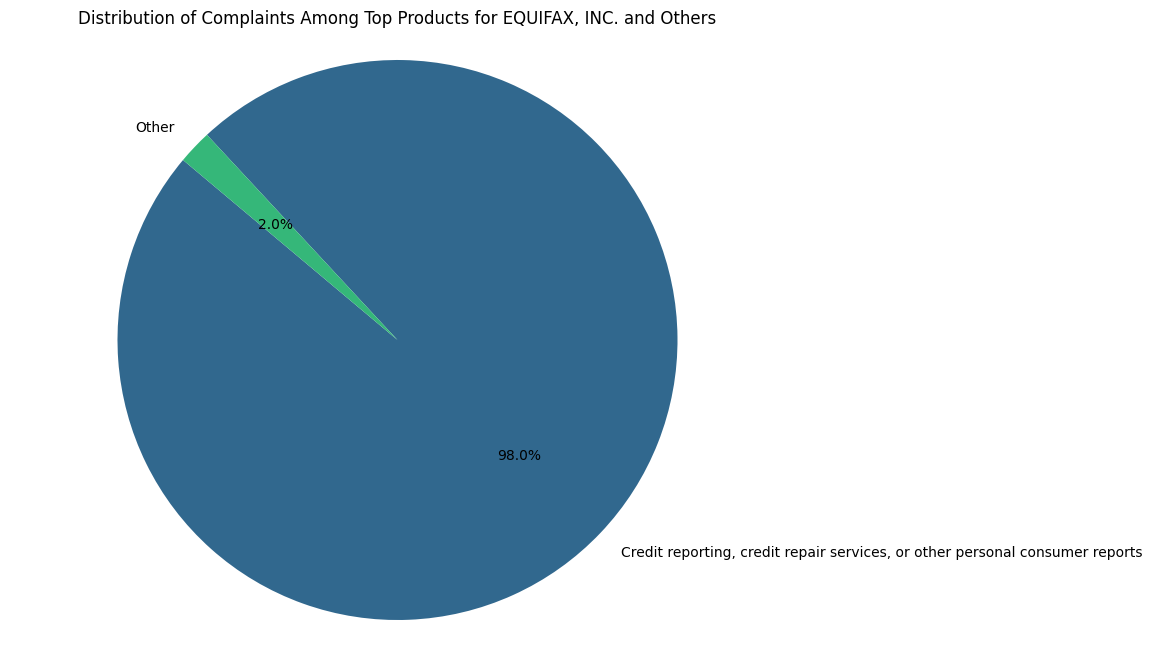

Selected product: Credit reporting, credit repair services, or other personal consumer reports
Top 10 sub-products:
                      Sub-product  Number of Complaints  Percentage
1                Credit reporting               1103523   99.627229
2  Other personal consumer report                  3561    0.321491
0          Credit repair services                   568    0.051280


/var/folders/zr/gzwryy5s75s63h4qbx6269tc0000gn/T/ipykernel_2537/2657370172.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Number of Complaints', y='Sub-product', data=top_sub_products, palette='viridis')


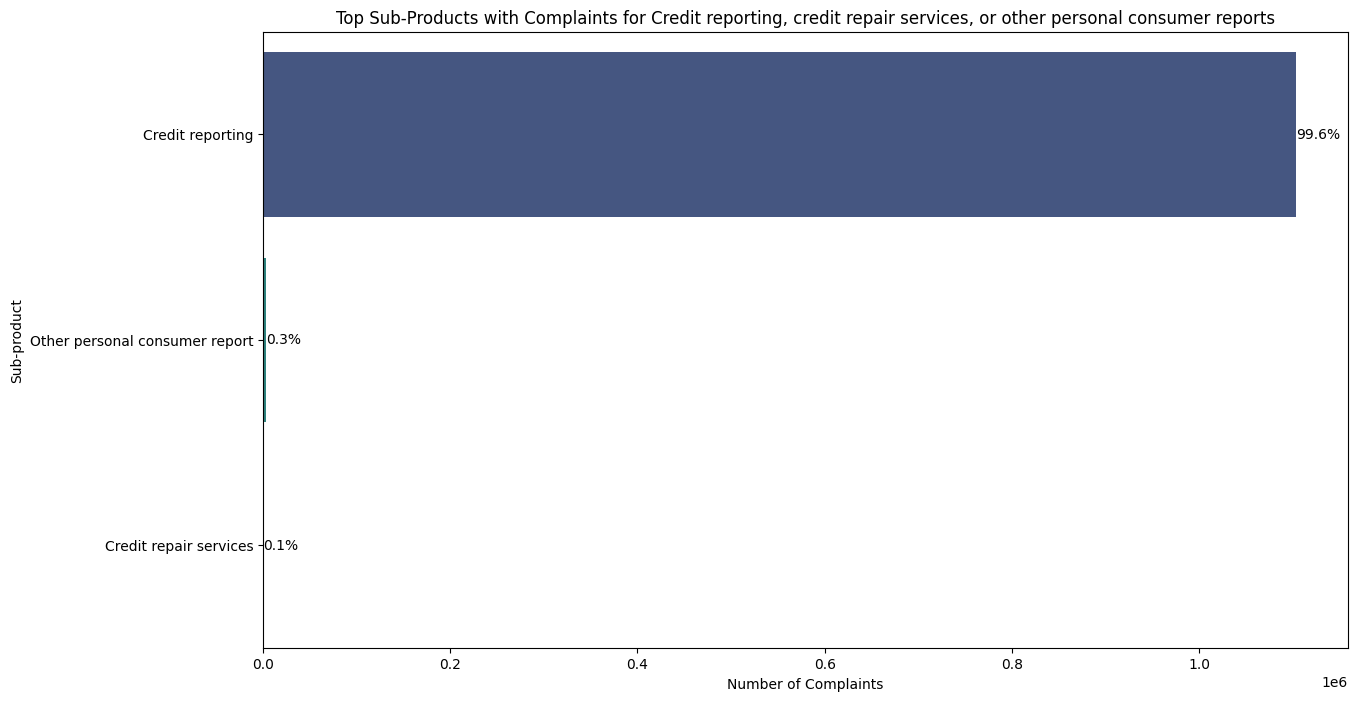

Selected sub-product: Credit reporting
Top 10 issues:
                                                Issue  Number of Complaints  \
6                Incorrect information on your report                514826   
5                         Improper use of your report                280530   
8   Problem with a credit reporting company's inve...                199452   
7   Problem with a company's investigation into an...                 84549   
10   Unable to get your credit report or credit score                 12527   
9       Problem with fraud alerts or security freezes                  6255   
1   Credit monitoring or identity theft protection...                  5380   
0                                  Closing an account                     1   
2                               Getting a credit card                     1   
3                                      Getting a loan                     1   

    Percentage  
6    46.652989  
5    25.421333  
8    18.074130  
7     7.

/var/folders/zr/gzwryy5s75s63h4qbx6269tc0000gn/T/ipykernel_2537/2657370172.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Number of Complaints', y='Issue', data=top_issues, palette='viridis')


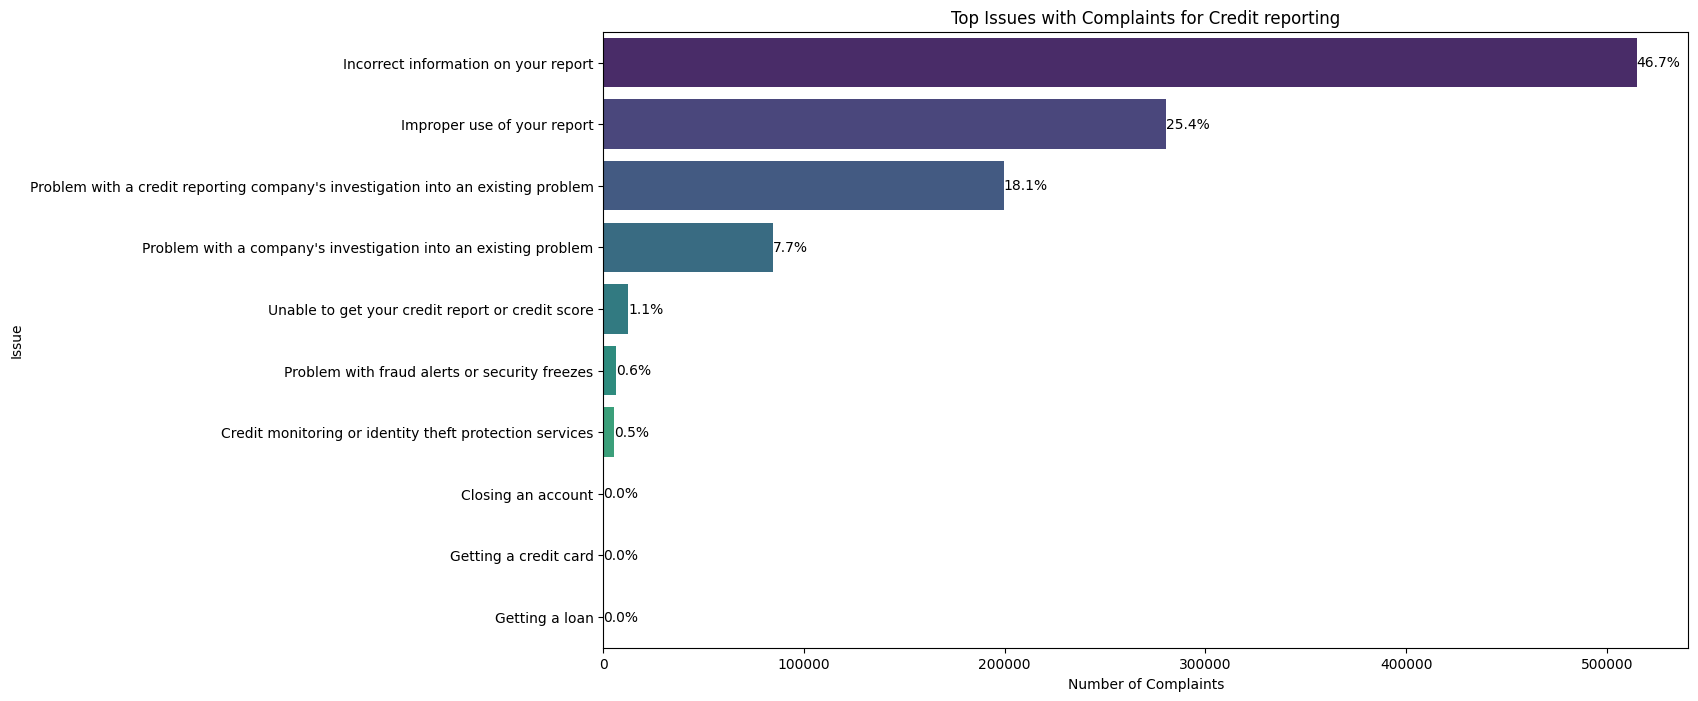

Top 3 issues:                                                Issue  Number of Complaints  \
6               Incorrect information on your report                514826   
5                        Improper use of your report                280530   
8  Problem with a credit reporting company's inve...                199452   

   Percentage  
6   46.652989  
5   25.421333  
8   18.074130  
Top 10 sub-issues for Incorrect information on your report:
                                           Sub-issue  Number of Complaints  \
2                Information belongs to someone else                368493   
0                      Account information incorrect                 51877   
1                           Account status incorrect                 44589   
7                     Personal information incorrect                 32247   
6       Old information reappears or never goes away                  7205   
8               Public record information inaccurate                  7121   
4  

/var/folders/zr/gzwryy5s75s63h4qbx6269tc0000gn/T/ipykernel_2537/2657370172.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Number of Complaints', y='Sub-issue', data=sub_issues, palette='viridis')


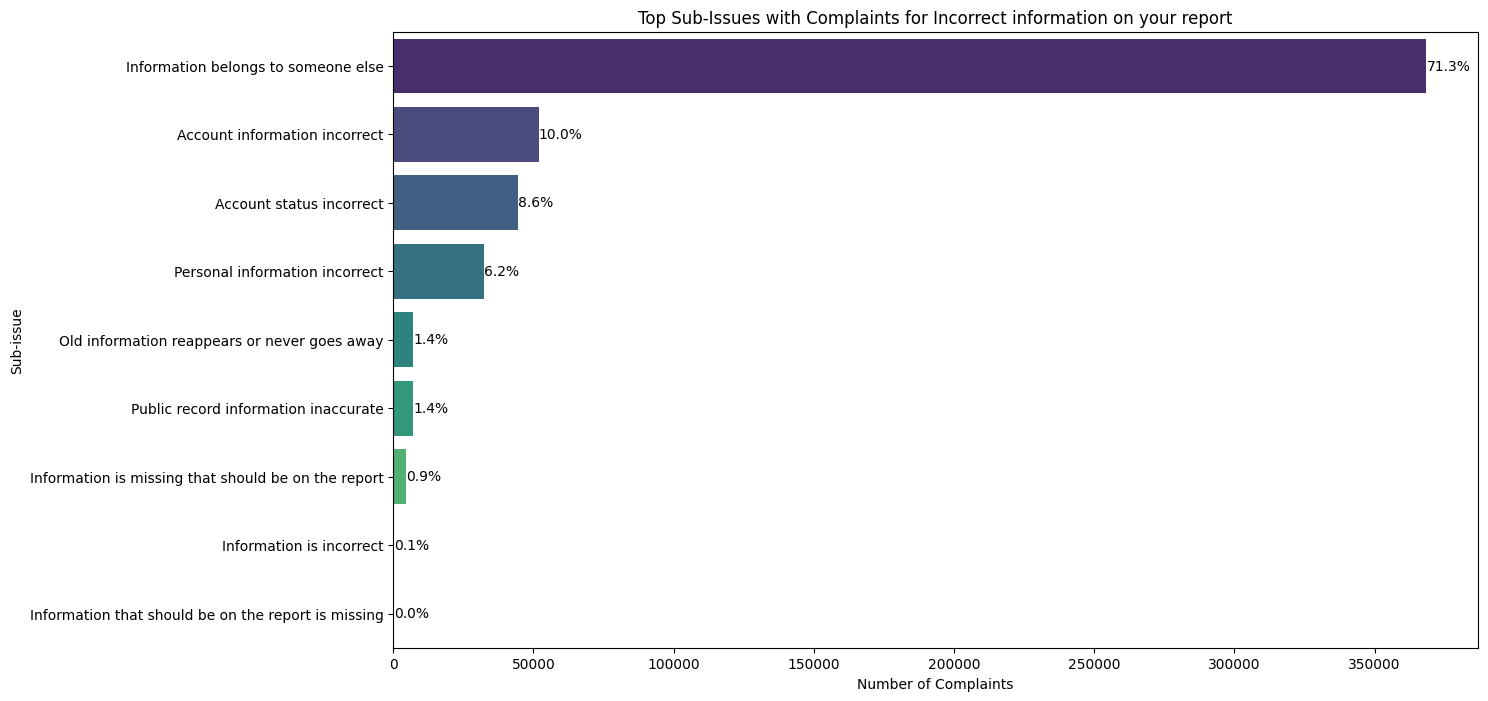

/var/folders/zr/gzwryy5s75s63h4qbx6269tc0000gn/T/ipykernel_2537/2657370172.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Number of Complaints', y='Sub-issue', data=sub_issues, palette='viridis')


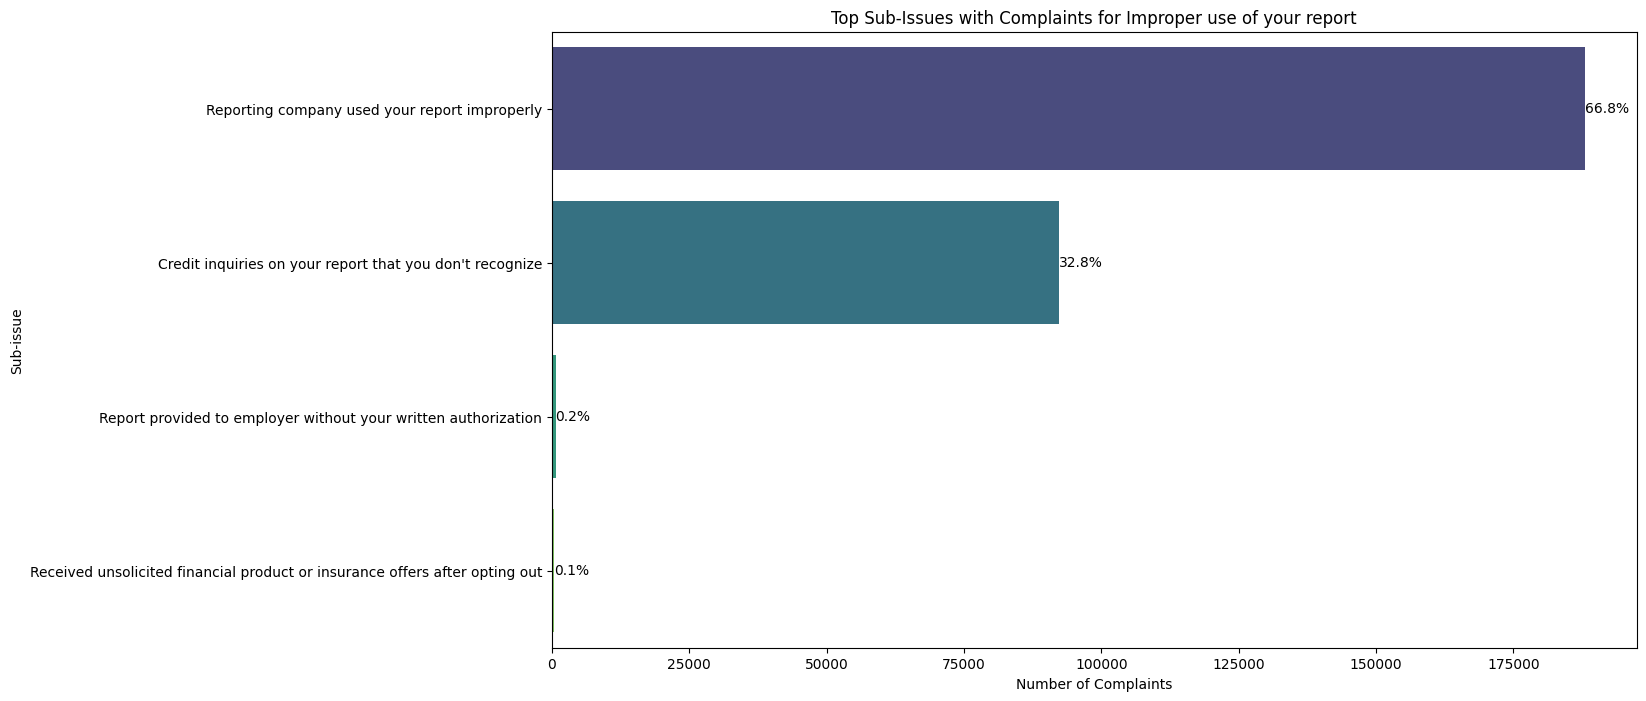

/var/folders/zr/gzwryy5s75s63h4qbx6269tc0000gn/T/ipykernel_2537/2657370172.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Number of Complaints', y='Sub-issue', data=sub_issues, palette='viridis')


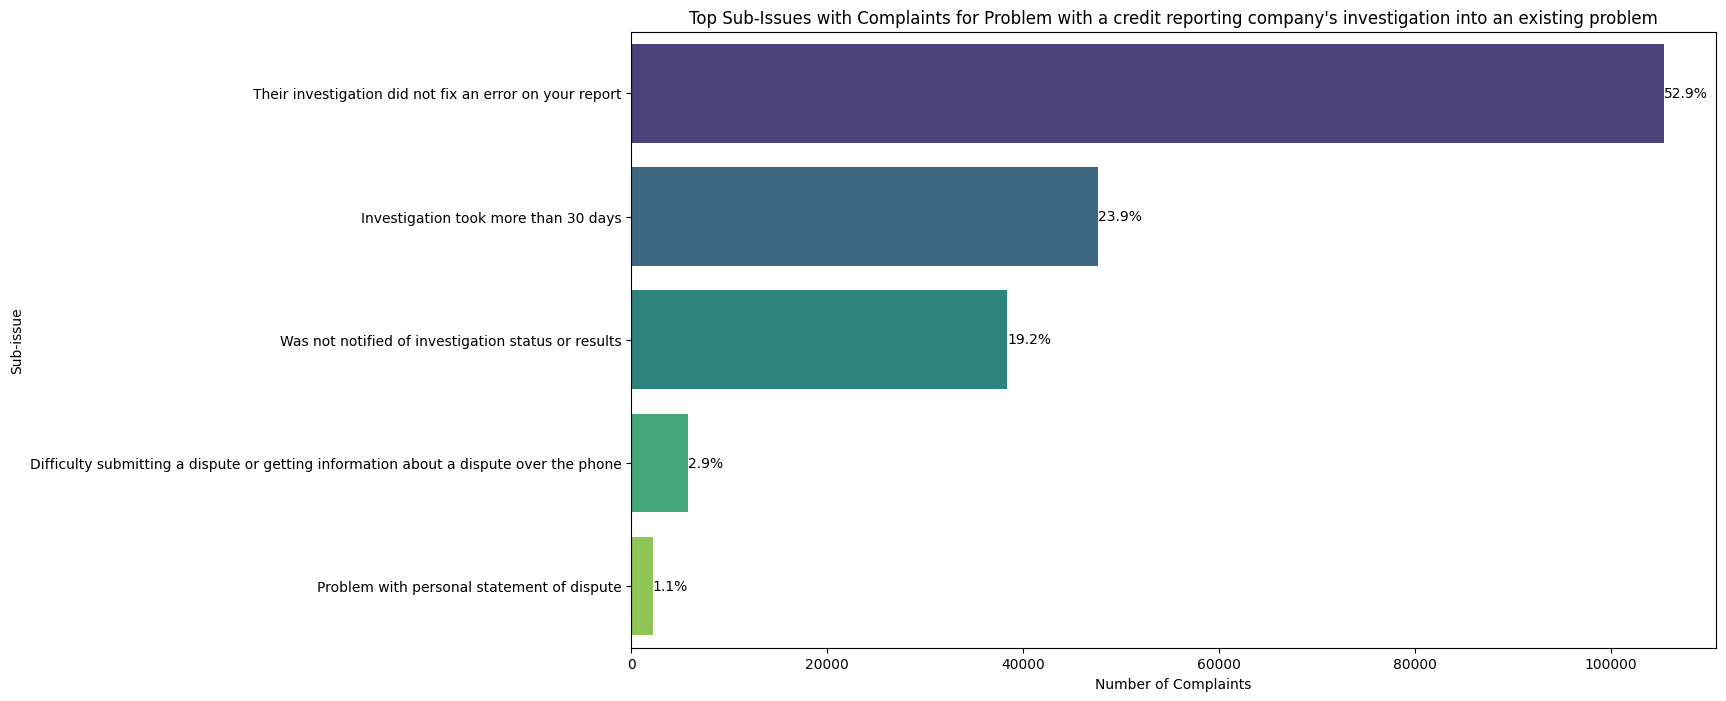

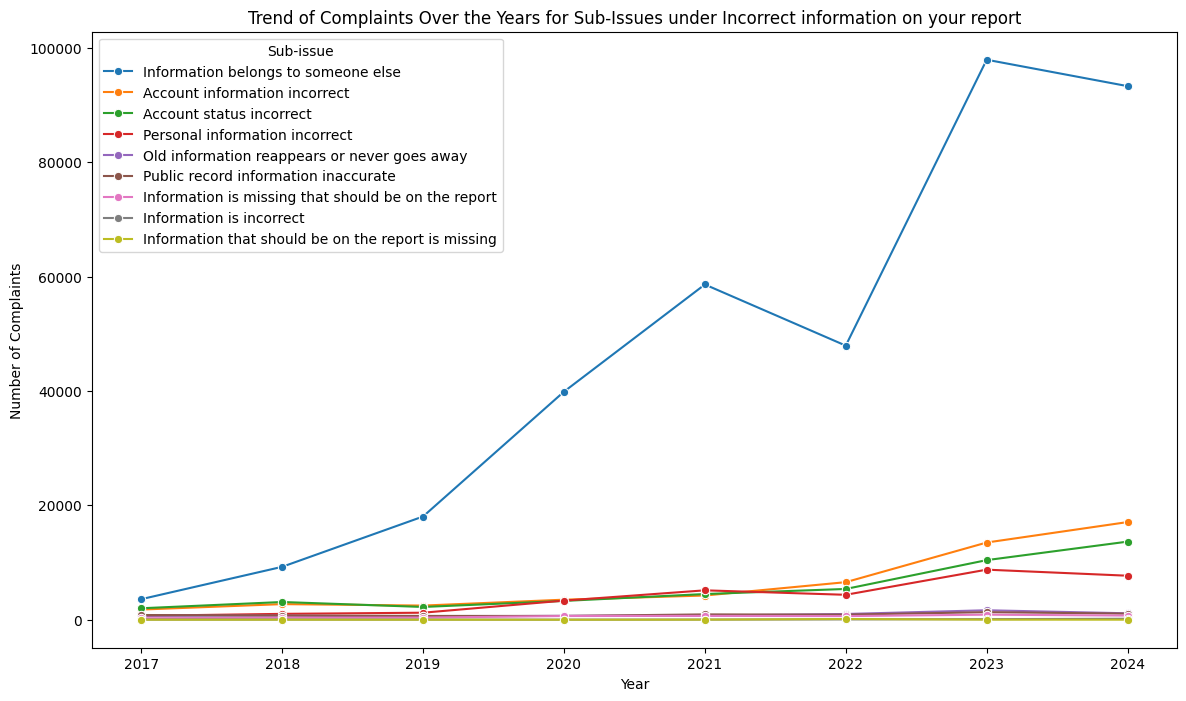

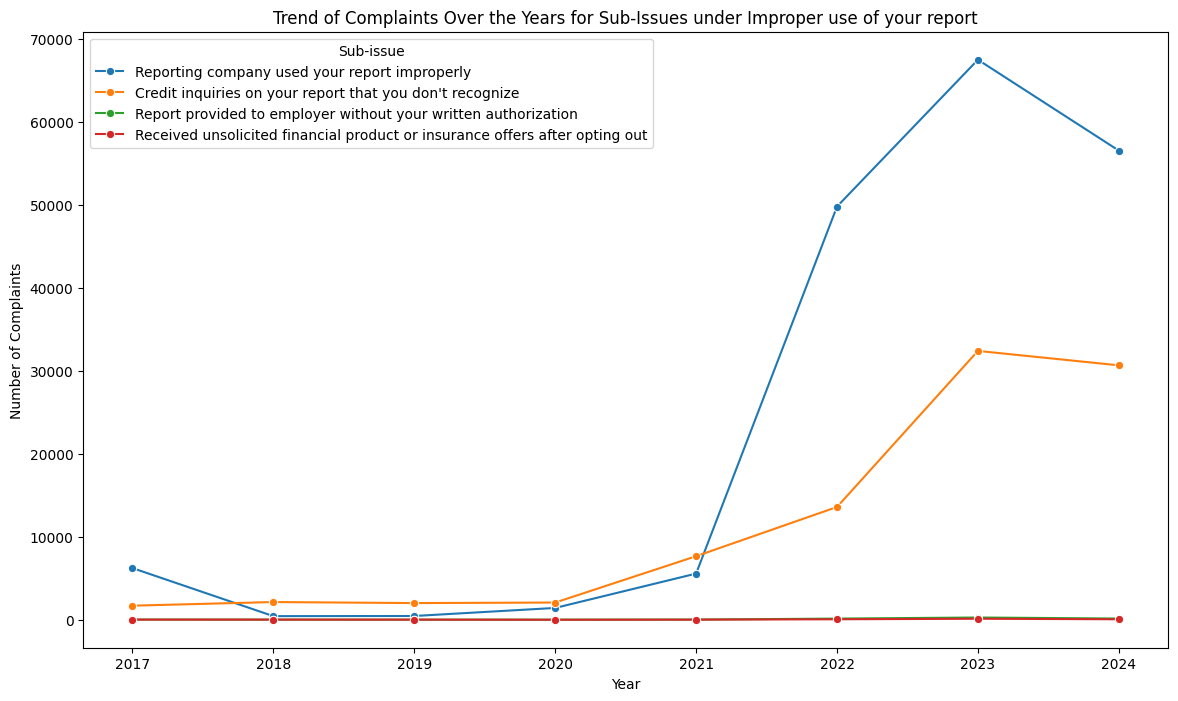

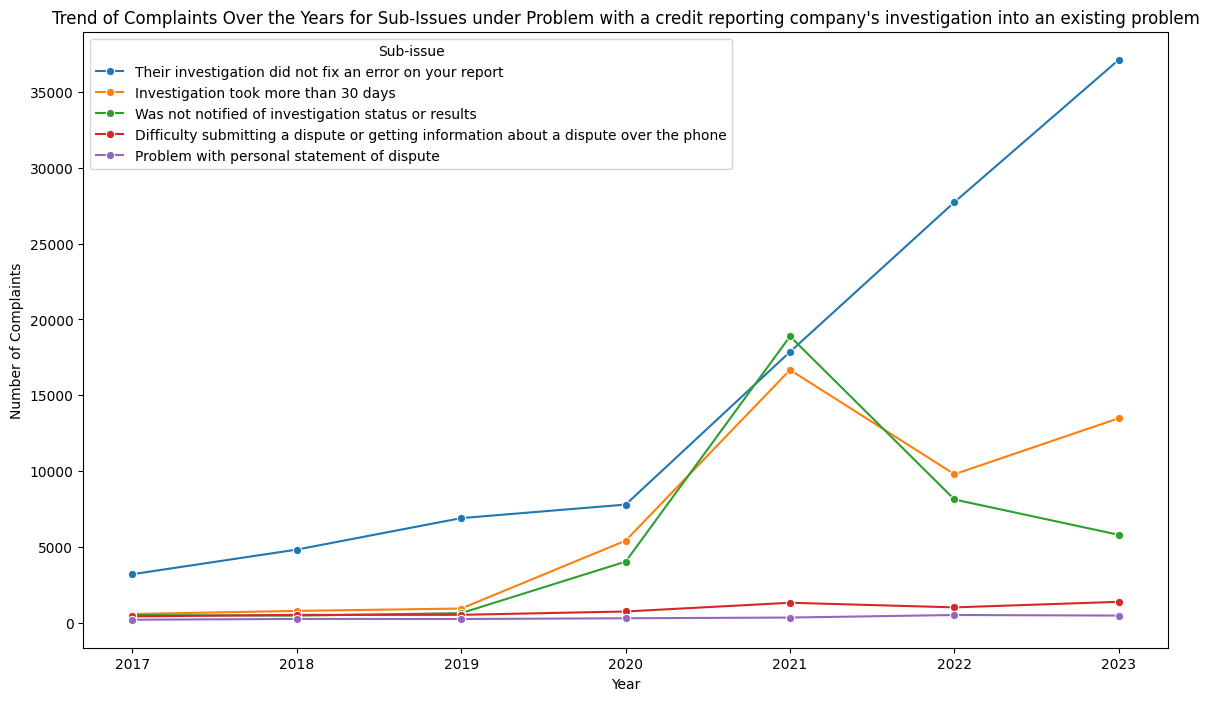

/var/folders/zr/gzwryy5s75s63h4qbx6269tc0000gn/T/ipykernel_2537/2657370172.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=timely_response_counts.index, y=timely_response_counts.values, palette='viridis')
/var/folders/zr/gzwryy5s75s63h4qbx6269tc0000gn/T/ipykernel_2537/2657370172.py:109: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percentage = timely_response_percentages[i]


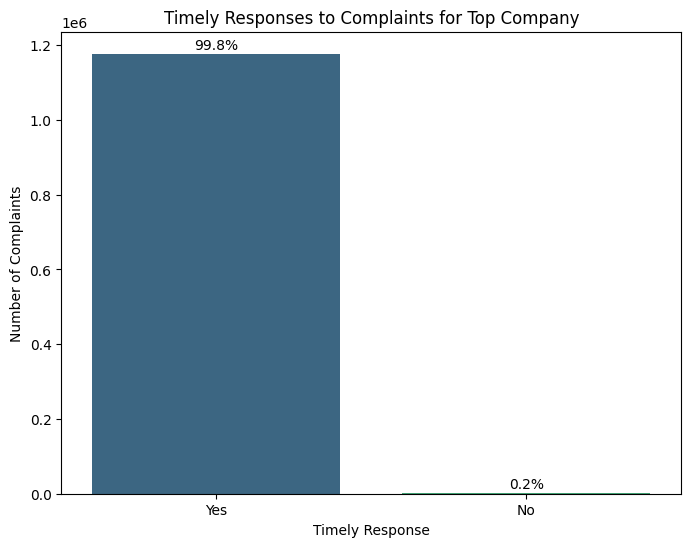

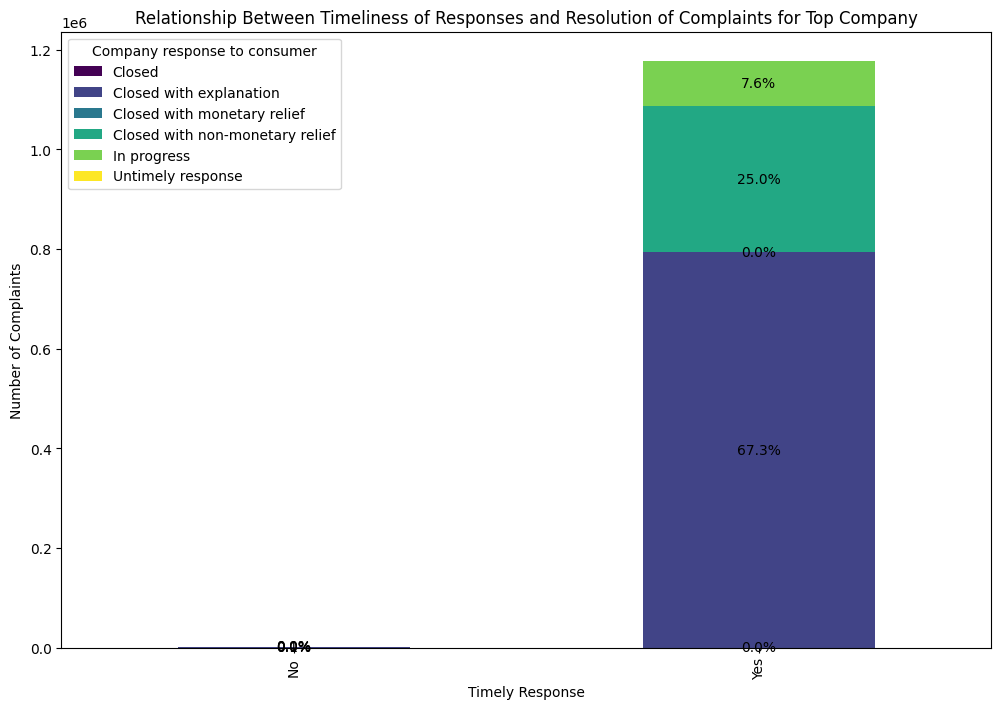

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


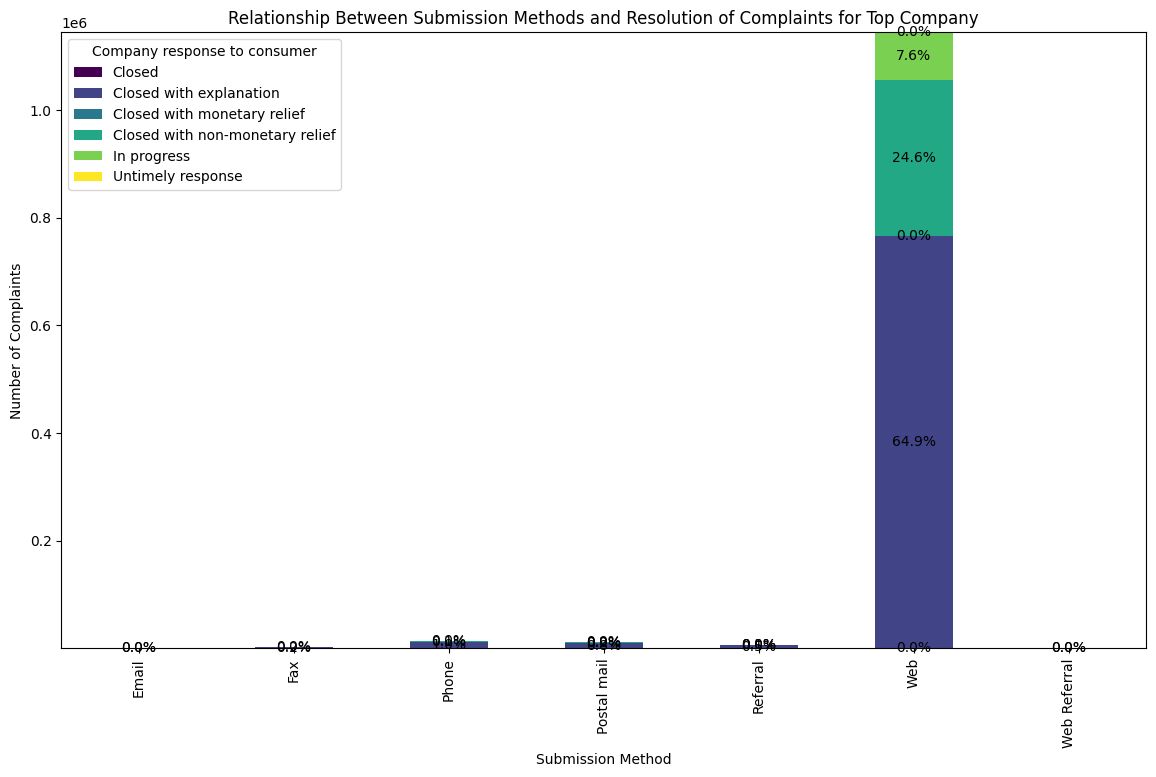

  State  Number of Complaints
0    AA                     5
1    AE                   185
2    AK                   645
3    AL                 28906
4    AP                    95


In [19]:
get_analysis(top_3_companies[0])

Top company: TRANSUNION INTERMEDIATE HOLDINGS, INC.
Top 10 products with 'Other':
                                             Product  Number of Complaints
0  Credit reporting, credit repair services, or o...               1076821
1                                              Other                 24718


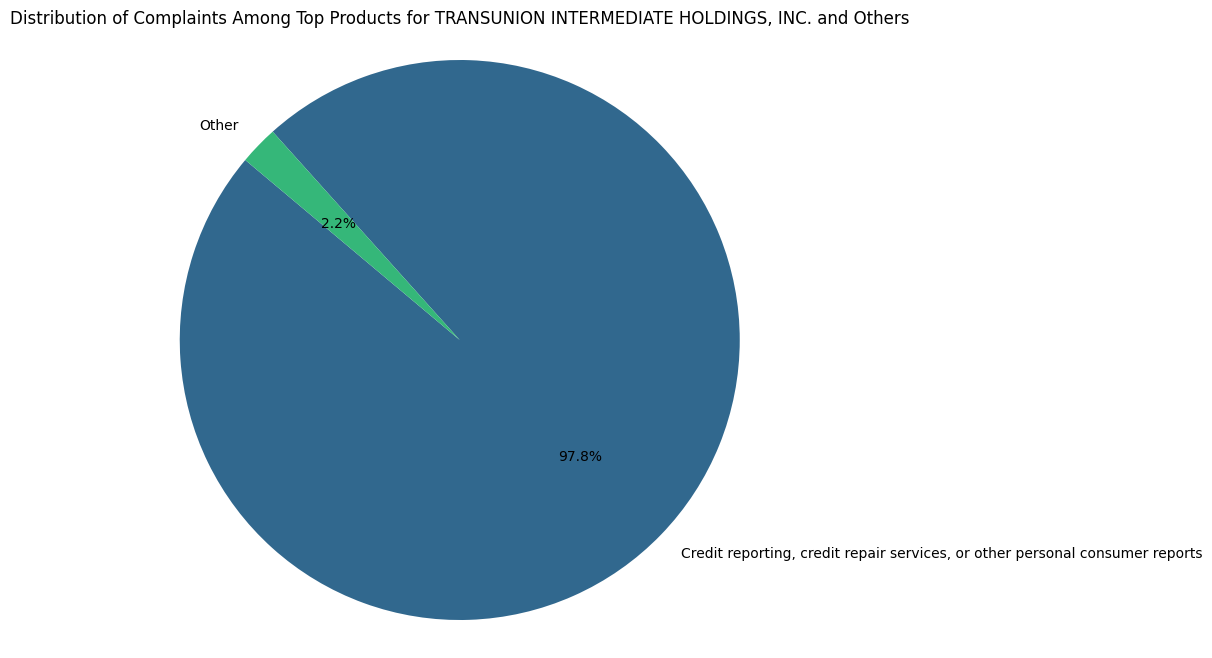

Selected product: Credit reporting, credit repair services, or other personal consumer reports
Top 10 sub-products:
                      Sub-product  Number of Complaints  Percentage
1                Credit reporting               1033074   99.621408
2  Other personal consumer report                  3369    0.324879
0          Credit repair services                   557    0.053713


/var/folders/zr/gzwryy5s75s63h4qbx6269tc0000gn/T/ipykernel_2537/2657370172.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Number of Complaints', y='Sub-product', data=top_sub_products, palette='viridis')


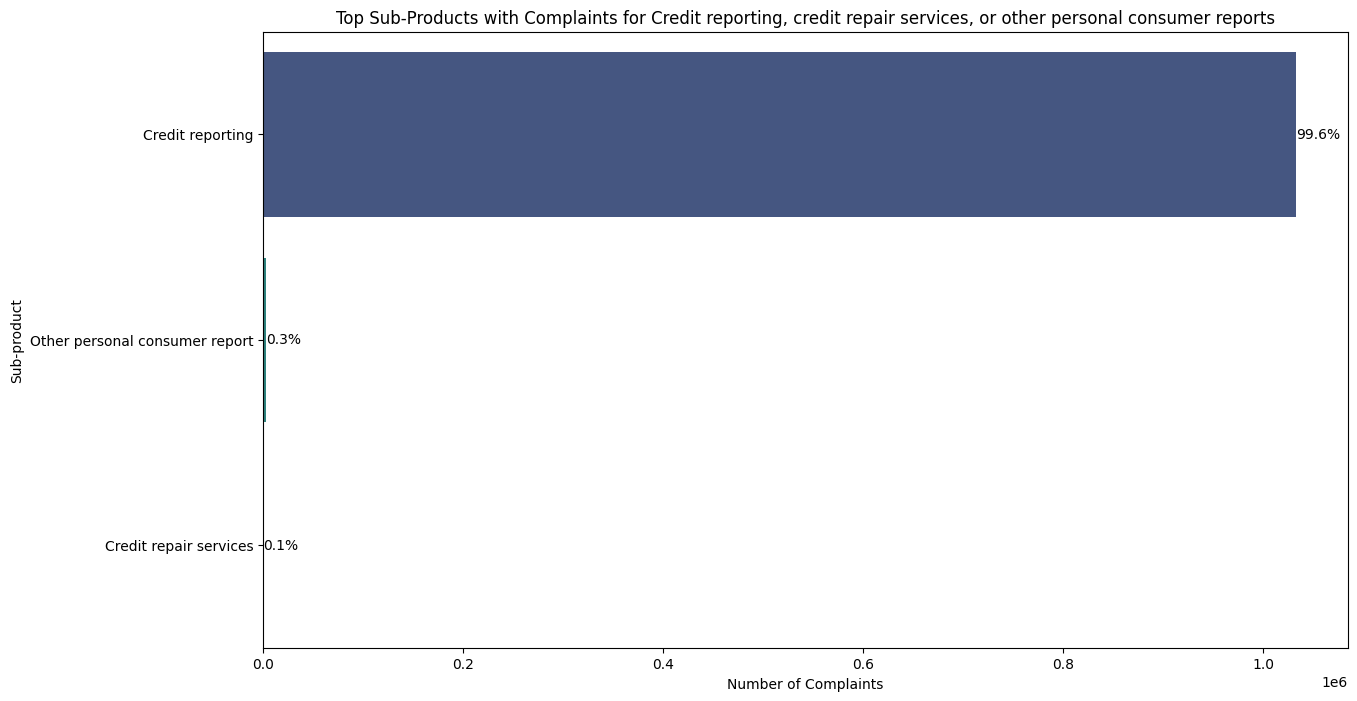

Selected sub-product: Credit reporting
Top 10 issues:
                                                Issue  Number of Complaints  \
6                Incorrect information on your report                489953   
5                         Improper use of your report                272085   
9   Problem with a credit reporting company's inve...                168958   
8   Problem with a company's investigation into an...                 85059   
12   Unable to get your credit report or credit score                  8196   
2   Credit monitoring or identity theft protection...                  4686   
10      Problem with fraud alerts or security freezes                  4130   
4                             Getting a loan or lease                     2   
0                                  Closing an account                     1   
1                               Closing on a mortgage                     1   

    Percentage  
6    47.426847  
5    26.337493  
9    16.354926  
8     8.

/var/folders/zr/gzwryy5s75s63h4qbx6269tc0000gn/T/ipykernel_2537/2657370172.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Number of Complaints', y='Issue', data=top_issues, palette='viridis')


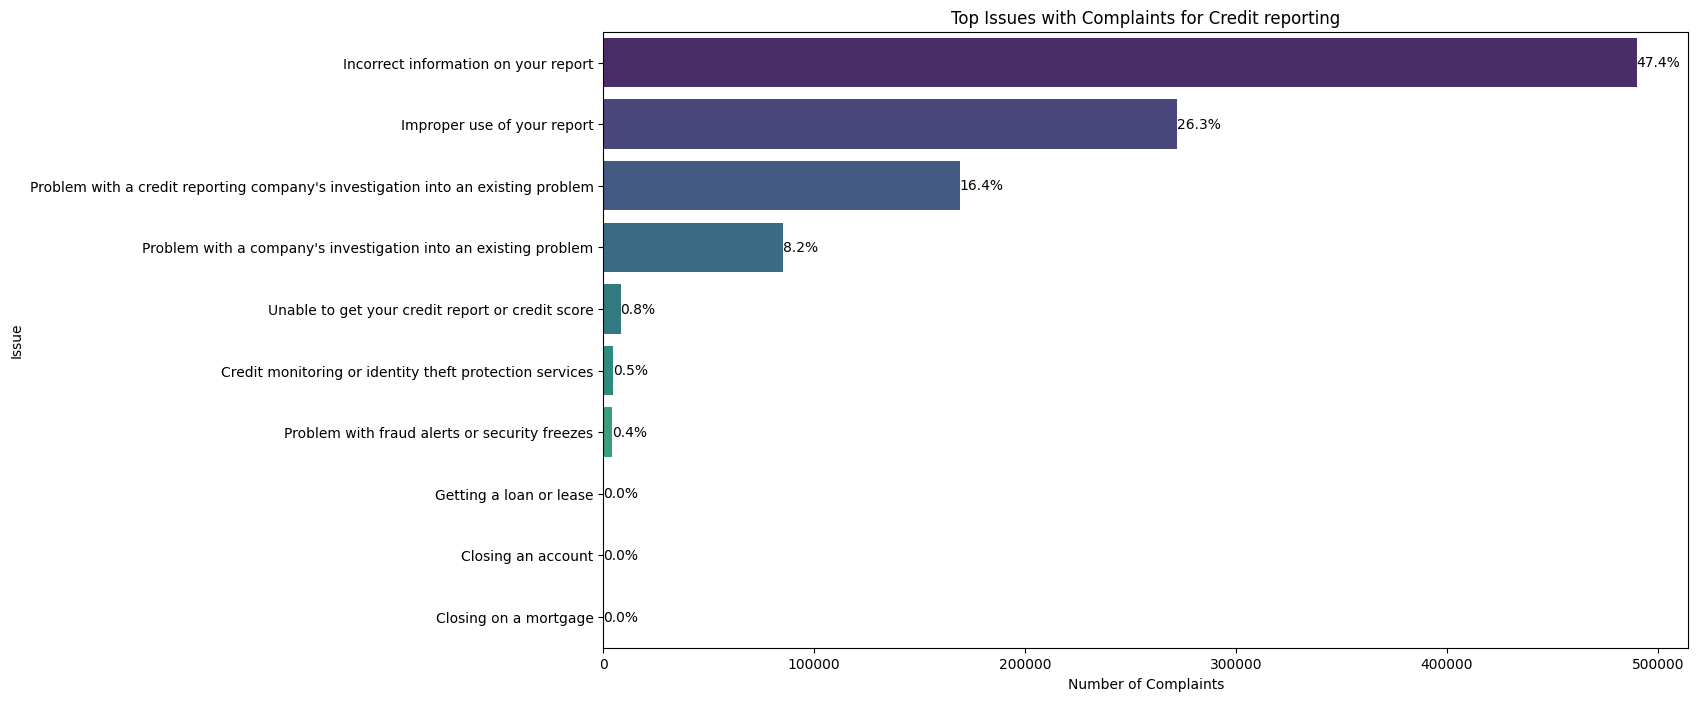

Top 3 issues:                                                Issue  Number of Complaints  \
6               Incorrect information on your report                489953   
5                        Improper use of your report                272085   
9  Problem with a credit reporting company's inve...                168958   

   Percentage  
6   47.426847  
5   26.337493  
9   16.354926  
Top 10 sub-issues for Incorrect information on your report:
                                           Sub-issue  Number of Complaints  \
2                Information belongs to someone else                347798   
0                      Account information incorrect                 52987   
1                           Account status incorrect                 43222   
7                     Personal information incorrect                 27859   
8               Public record information inaccurate                  8567   
6       Old information reappears or never goes away                  6893   
4  

/var/folders/zr/gzwryy5s75s63h4qbx6269tc0000gn/T/ipykernel_2537/2657370172.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Number of Complaints', y='Sub-issue', data=sub_issues, palette='viridis')


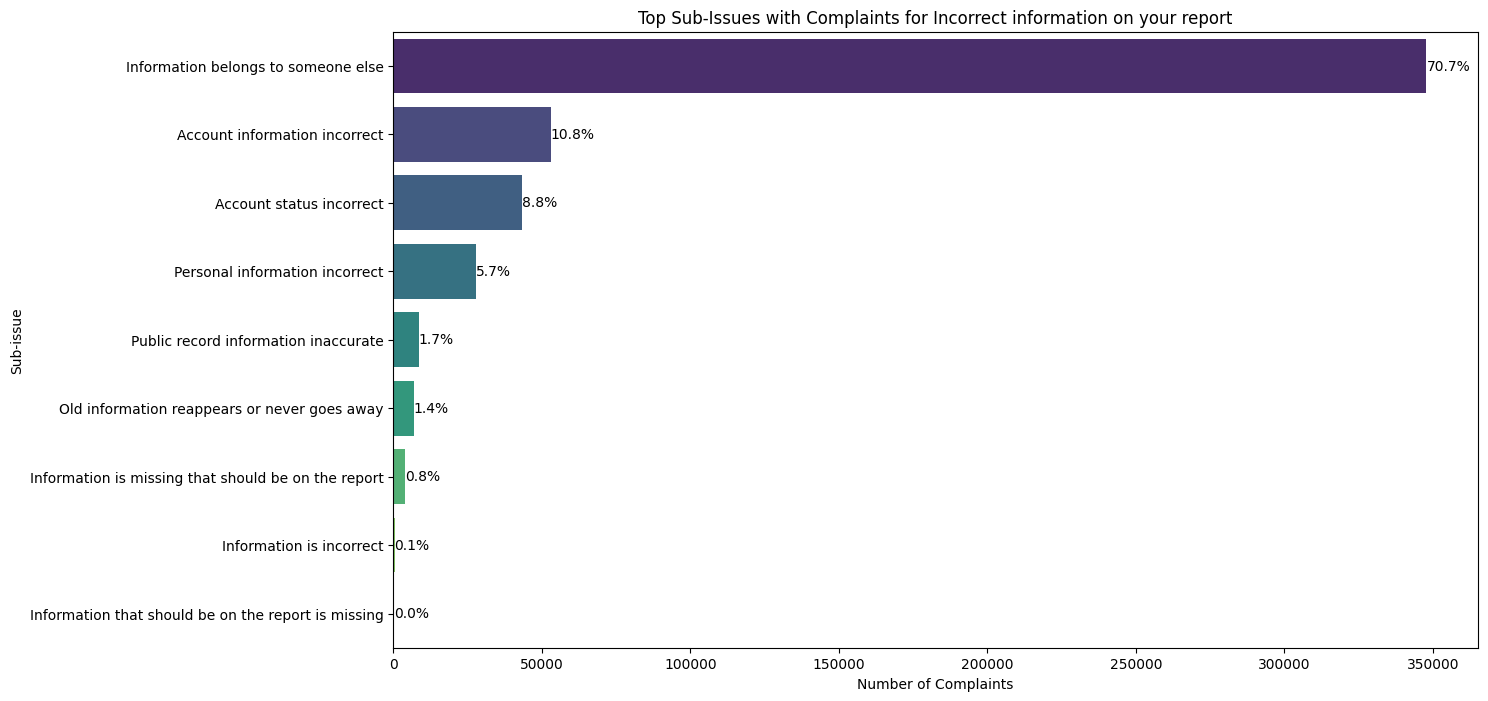

/var/folders/zr/gzwryy5s75s63h4qbx6269tc0000gn/T/ipykernel_2537/2657370172.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Number of Complaints', y='Sub-issue', data=sub_issues, palette='viridis')


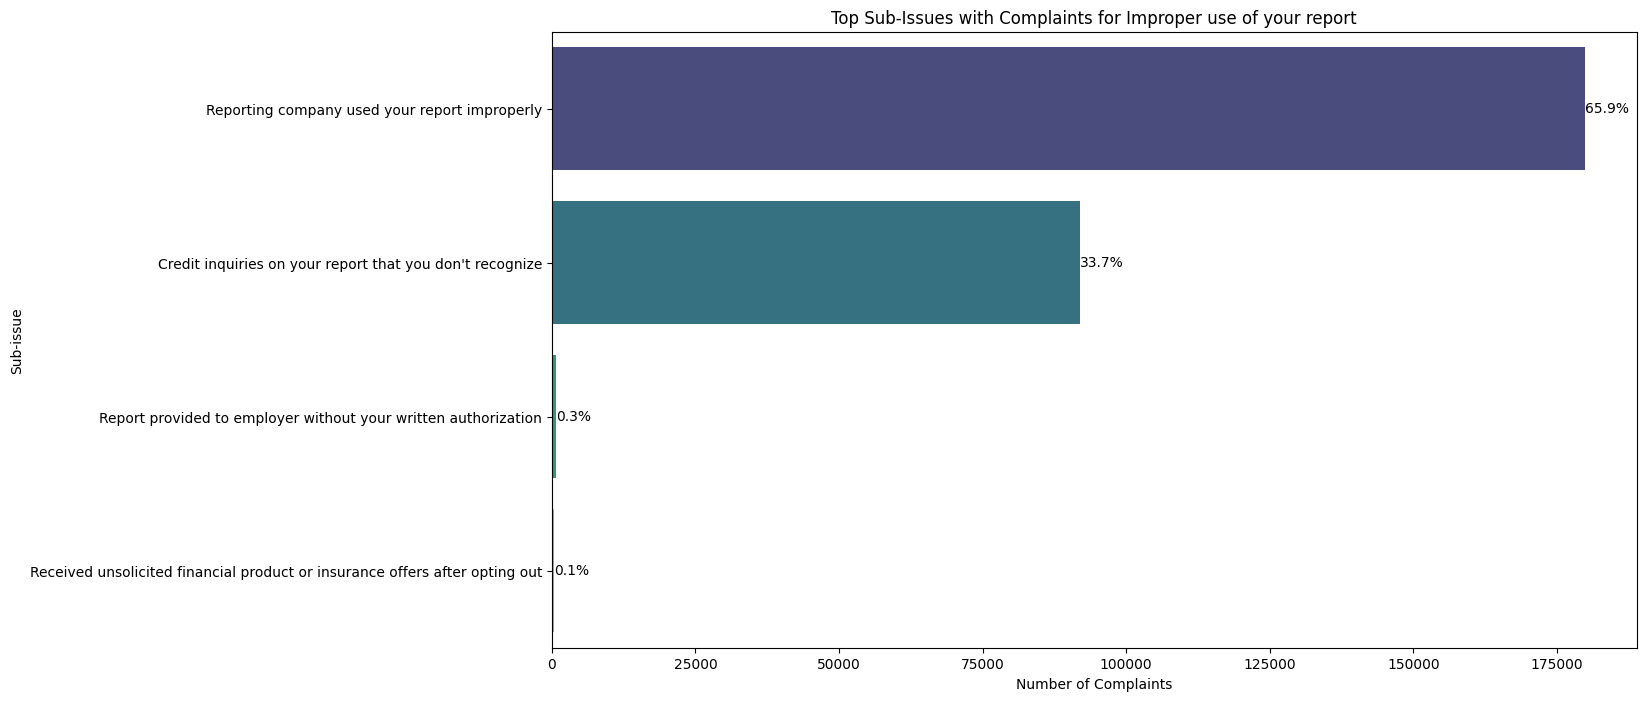

/var/folders/zr/gzwryy5s75s63h4qbx6269tc0000gn/T/ipykernel_2537/2657370172.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Number of Complaints', y='Sub-issue', data=sub_issues, palette='viridis')


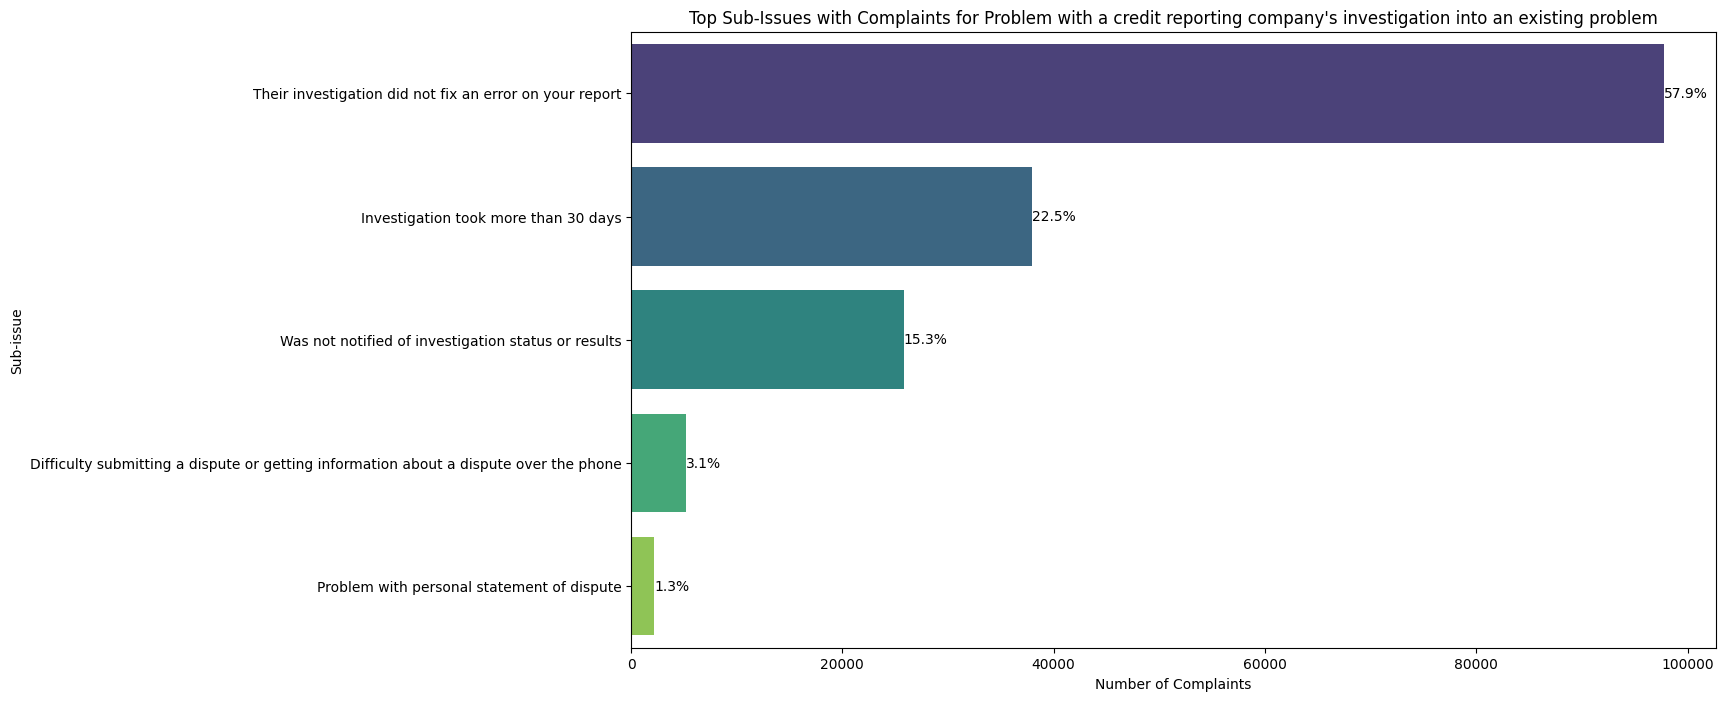

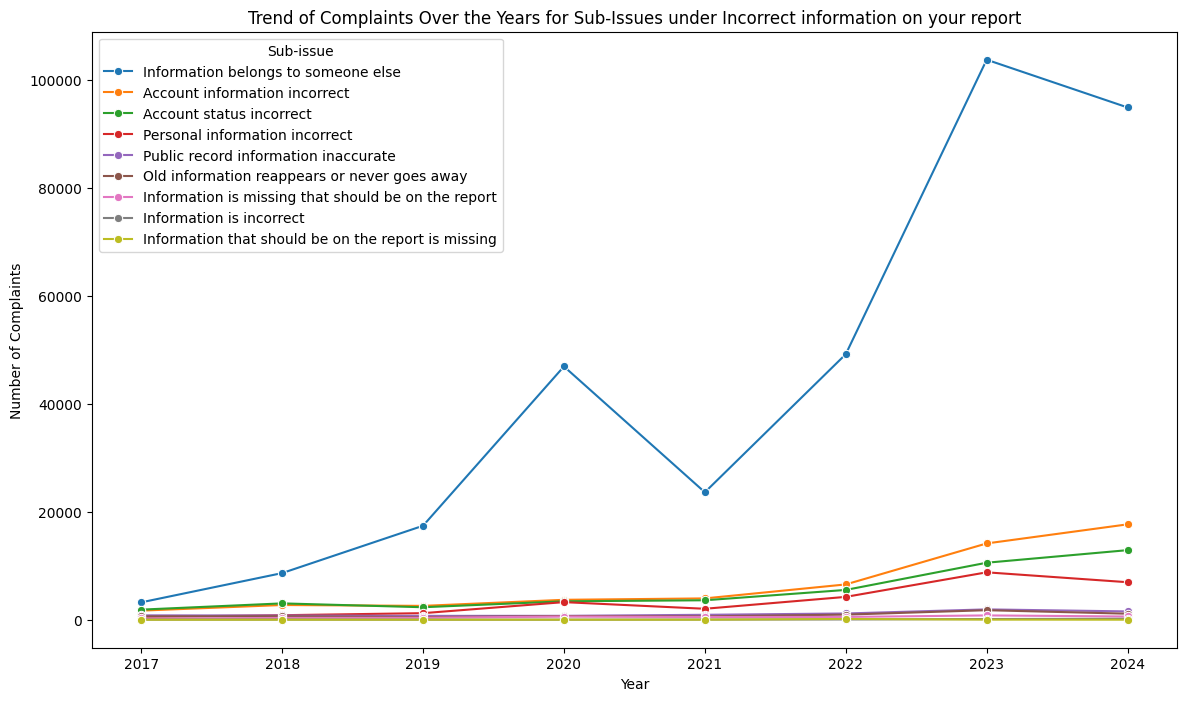

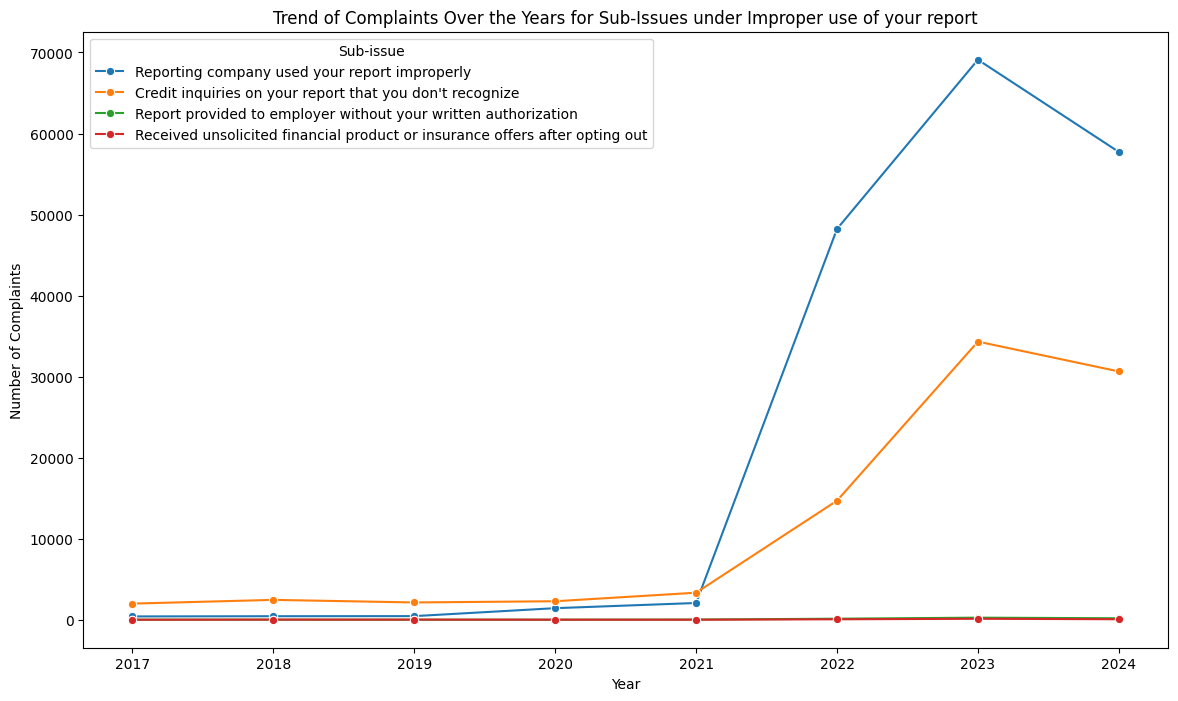

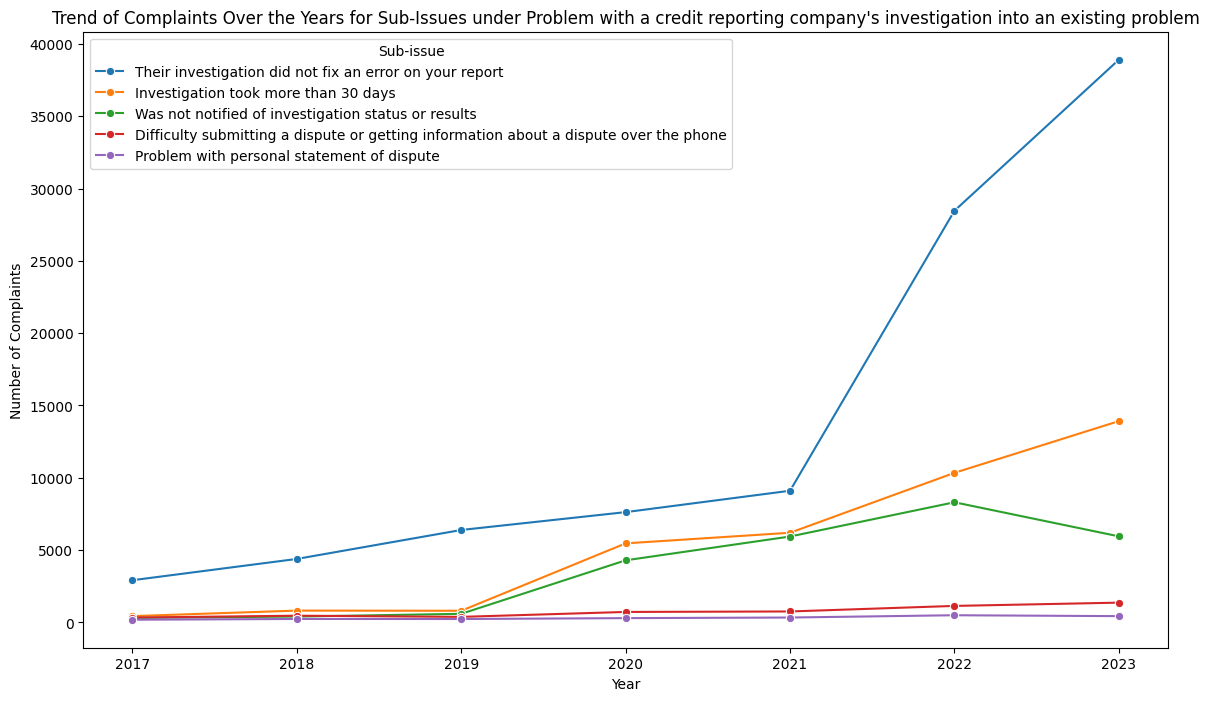

/var/folders/zr/gzwryy5s75s63h4qbx6269tc0000gn/T/ipykernel_2537/2657370172.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=timely_response_counts.index, y=timely_response_counts.values, palette='viridis')
/var/folders/zr/gzwryy5s75s63h4qbx6269tc0000gn/T/ipykernel_2537/2657370172.py:109: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percentage = timely_response_percentages[i]


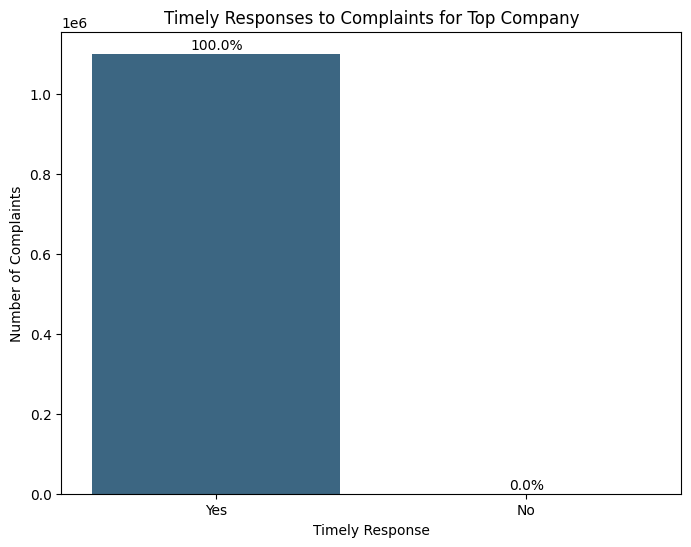

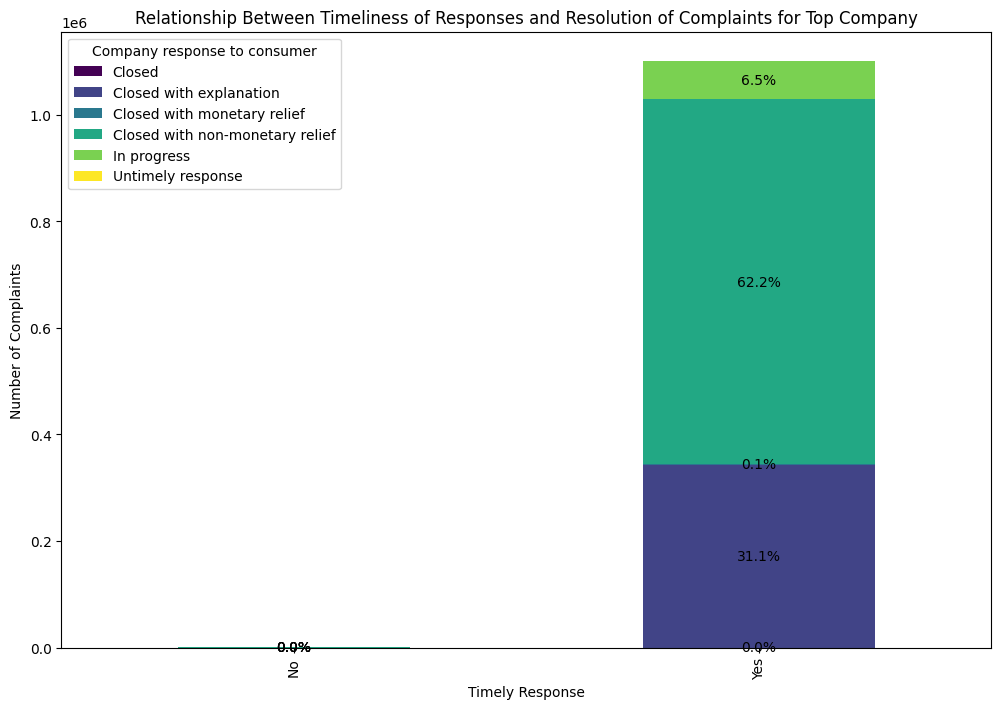

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


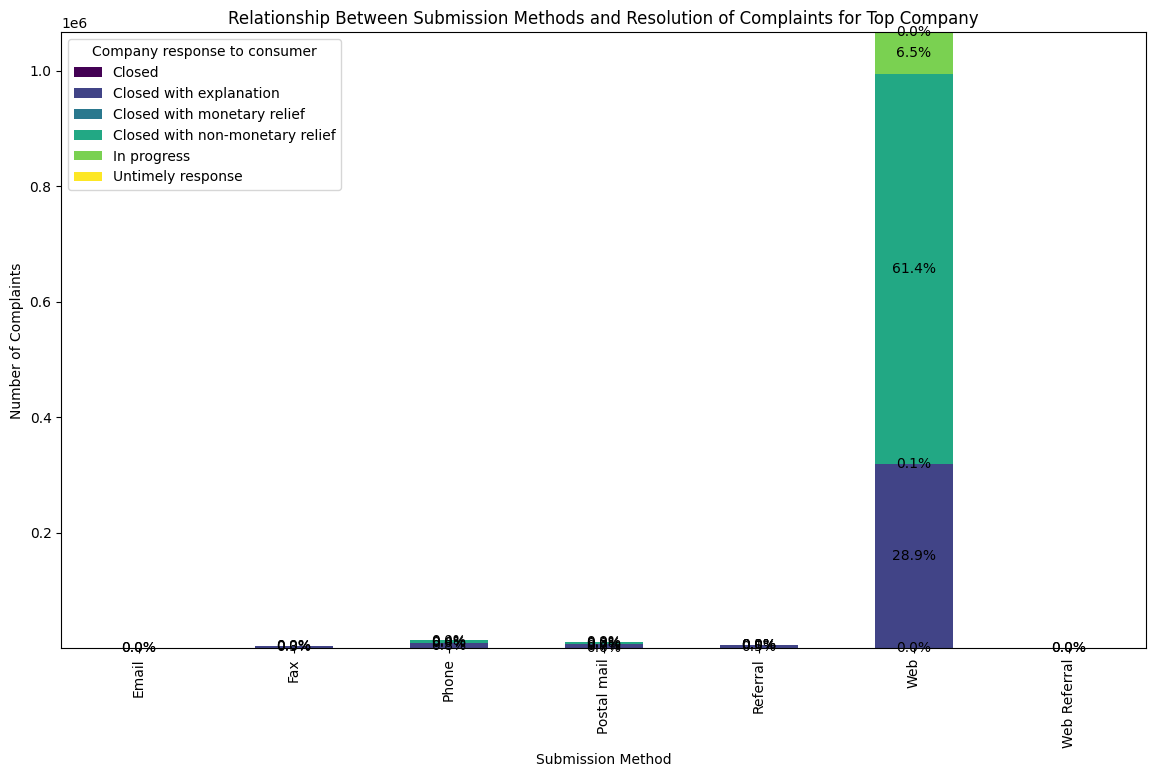

  State  Number of Complaints
0    AA                     5
1    AE                   191
2    AK                   599
3    AL                 24007
4    AP                    72


In [20]:
get_analysis(top_3_companies[1])

Top company: Experian Information Solutions Inc.
Top 10 products with 'Other':
                                             Product  Number of Complaints
0  Credit reporting, credit repair services, or o...                985323
1                                              Other                 23130


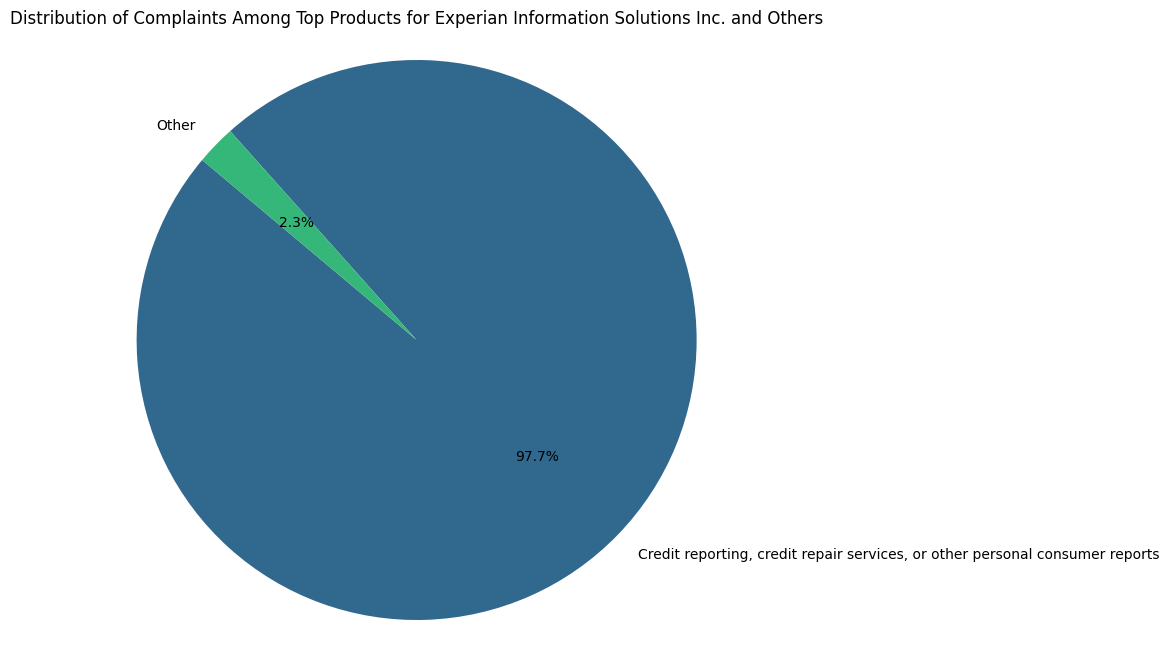

Selected product: Credit reporting, credit repair services, or other personal consumer reports
Top 10 sub-products:
                      Sub-product  Number of Complaints  Percentage
1                Credit reporting                935531   99.530398
2  Other personal consumer report                  3549    0.377575
0          Credit repair services                   865    0.092027


/var/folders/zr/gzwryy5s75s63h4qbx6269tc0000gn/T/ipykernel_2537/2657370172.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Number of Complaints', y='Sub-product', data=top_sub_products, palette='viridis')


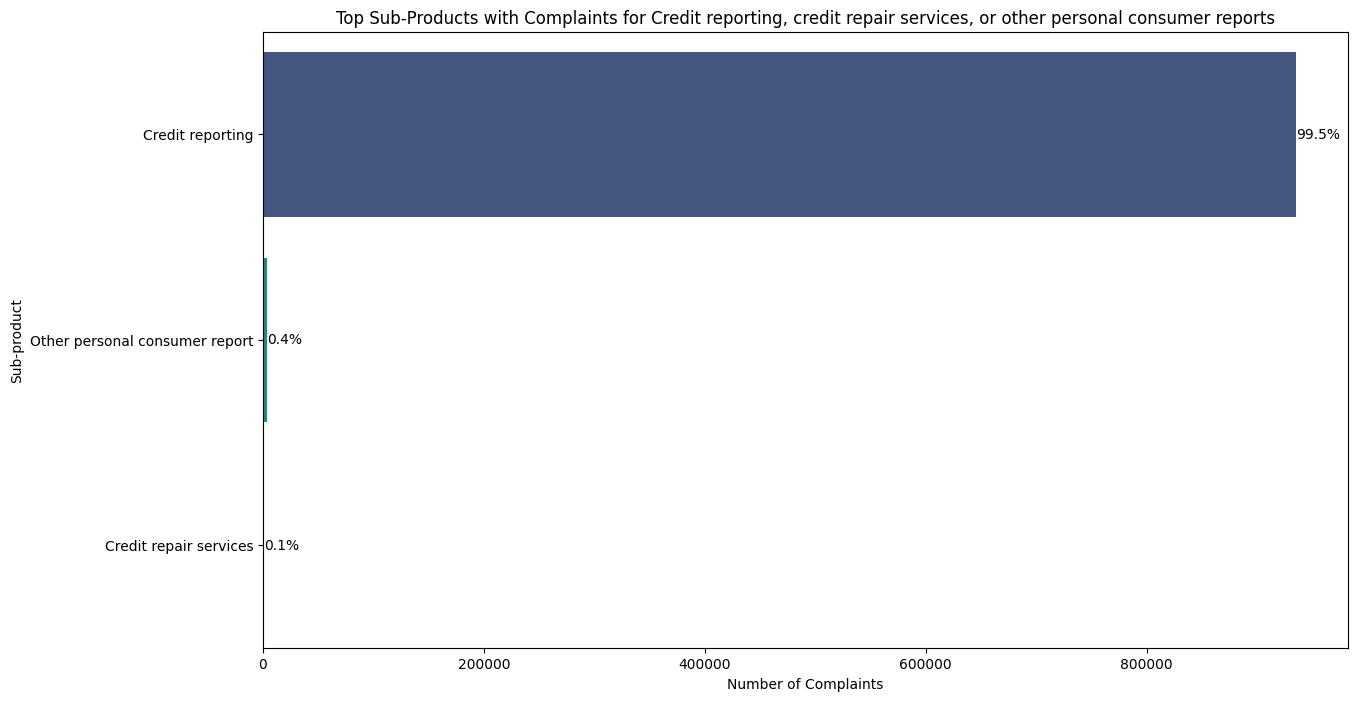

Selected sub-product: Credit reporting
Top 10 issues:
                                                Issue  Number of Complaints  \
5                Incorrect information on your report                442569   
4                         Improper use of your report                242621   
8   Problem with a credit reporting company's inve...                150334   
7   Problem with a company's investigation into an...                 81313   
11   Unable to get your credit report or credit score                  7603   
9       Problem with fraud alerts or security freezes                  6030   
0   Credit monitoring or identity theft protection...                  5053   
1                               Getting a credit card                     3   
3                             Getting a loan or lease                     2   
2                                      Getting a loan                     1   

    Percentage  
5    47.306818  
4    25.934097  
8    16.069411  
7     8.

/var/folders/zr/gzwryy5s75s63h4qbx6269tc0000gn/T/ipykernel_2537/2657370172.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Number of Complaints', y='Issue', data=top_issues, palette='viridis')


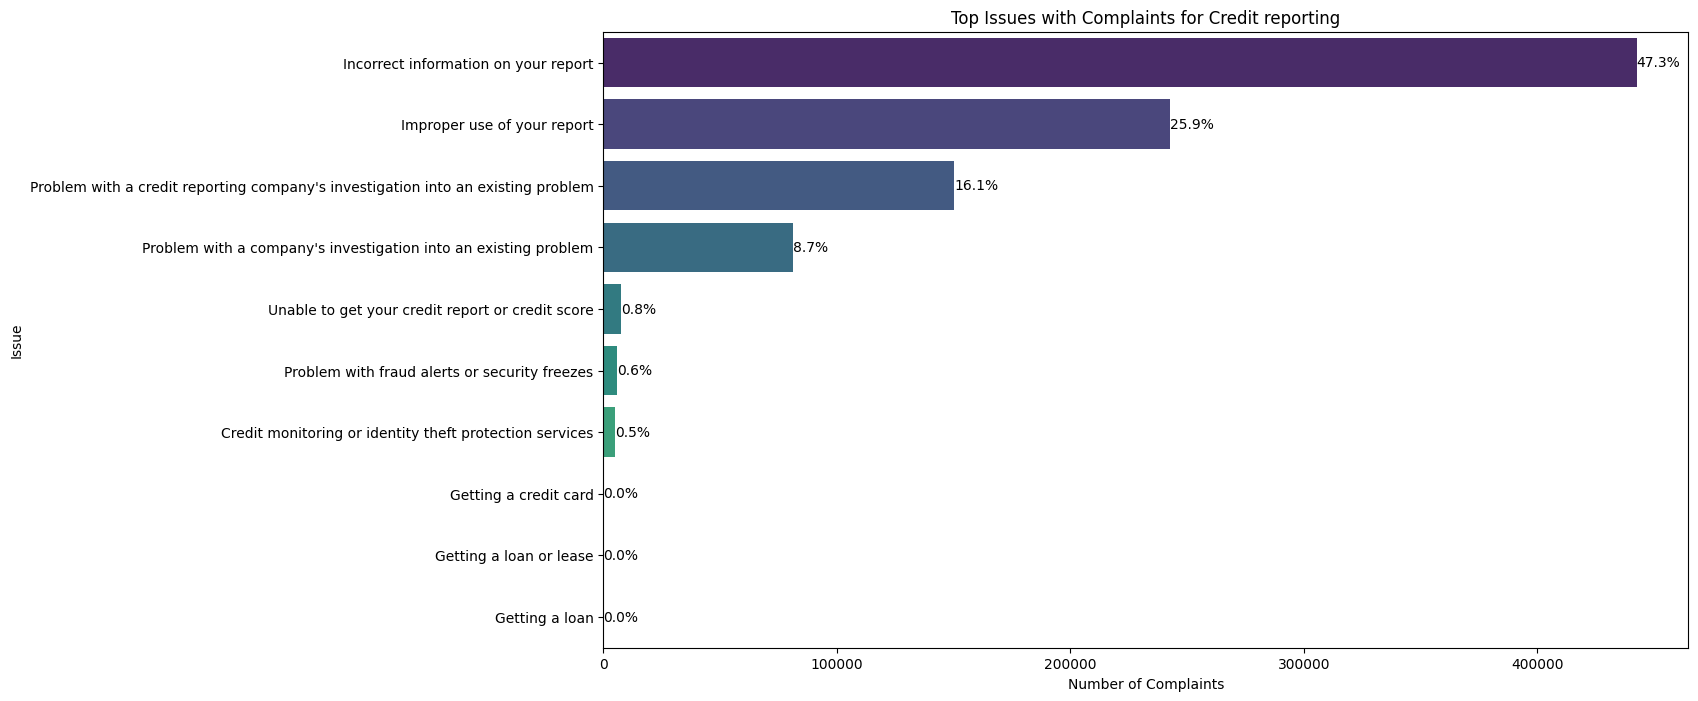

Top 3 issues:                                                Issue  Number of Complaints  \
5               Incorrect information on your report                442569   
4                        Improper use of your report                242621   
8  Problem with a credit reporting company's inve...                150334   

   Percentage  
5   47.306818  
4   25.934097  
8   16.069411  
Top 10 sub-issues for Incorrect information on your report:
                                           Sub-issue  Number of Complaints  \
2                Information belongs to someone else                297672   
0                      Account information incorrect                 51332   
1                           Account status incorrect                 42914   
7                     Personal information incorrect                 33040   
8               Public record information inaccurate                  7947   
6       Old information reappears or never goes away                  6989   
4  

/var/folders/zr/gzwryy5s75s63h4qbx6269tc0000gn/T/ipykernel_2537/2657370172.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Number of Complaints', y='Sub-issue', data=sub_issues, palette='viridis')


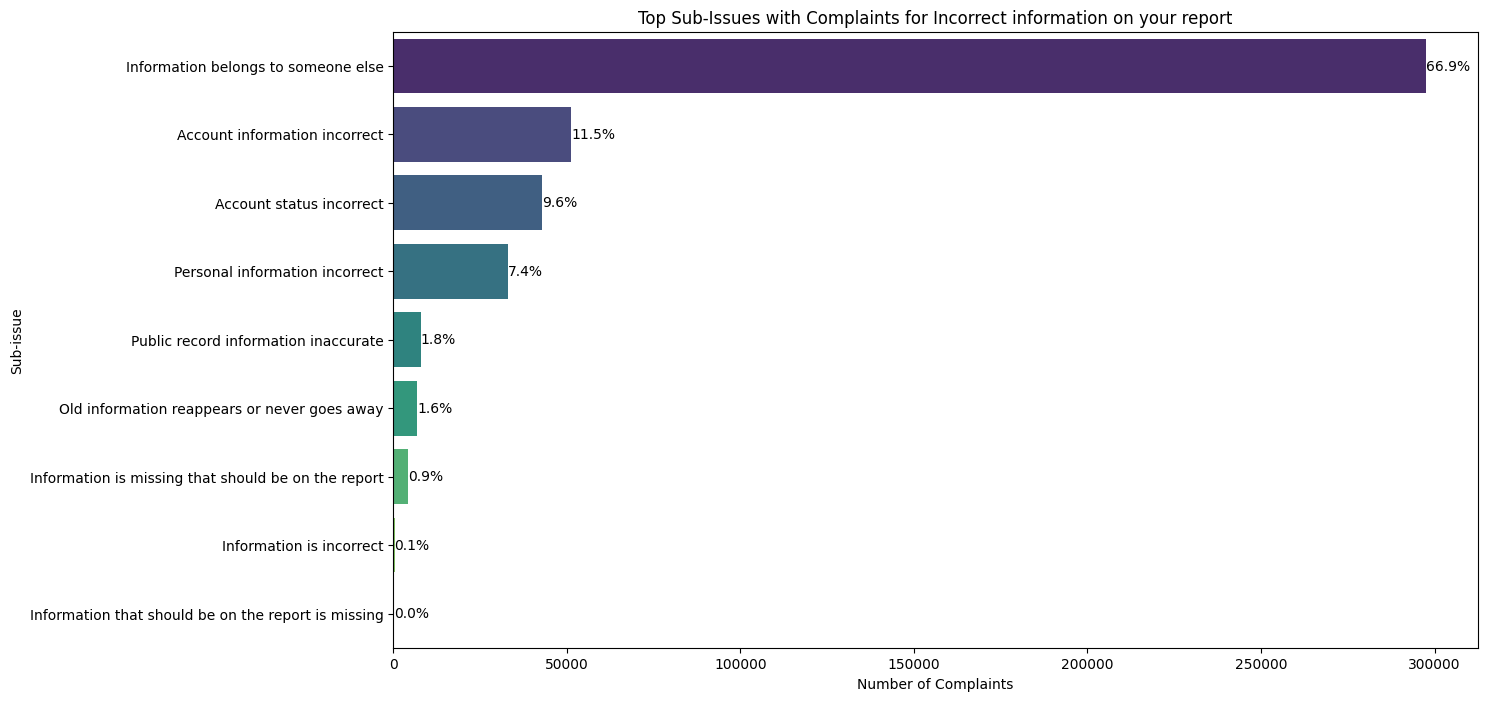

/var/folders/zr/gzwryy5s75s63h4qbx6269tc0000gn/T/ipykernel_2537/2657370172.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Number of Complaints', y='Sub-issue', data=sub_issues, palette='viridis')


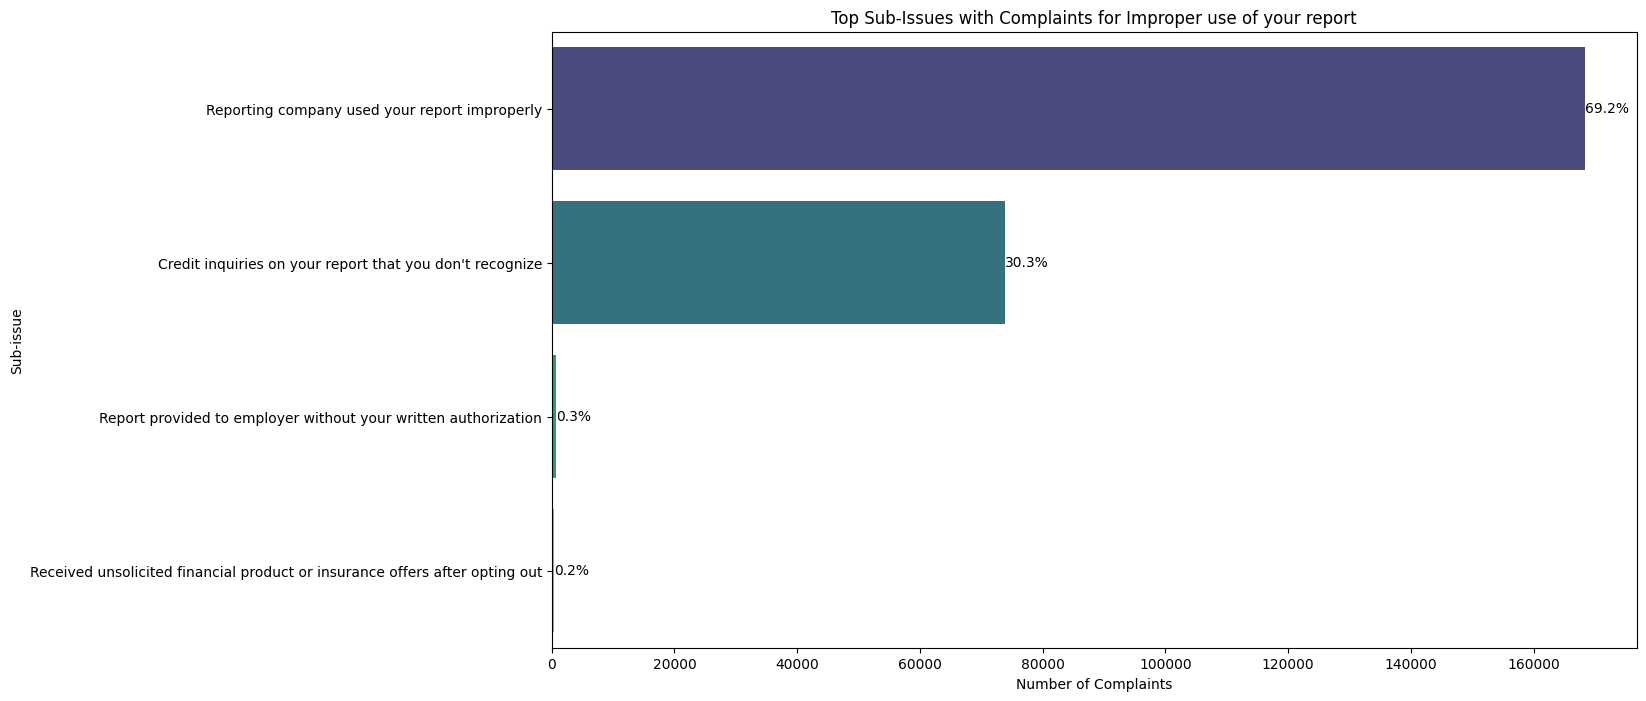

/var/folders/zr/gzwryy5s75s63h4qbx6269tc0000gn/T/ipykernel_2537/2657370172.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Number of Complaints', y='Sub-issue', data=sub_issues, palette='viridis')


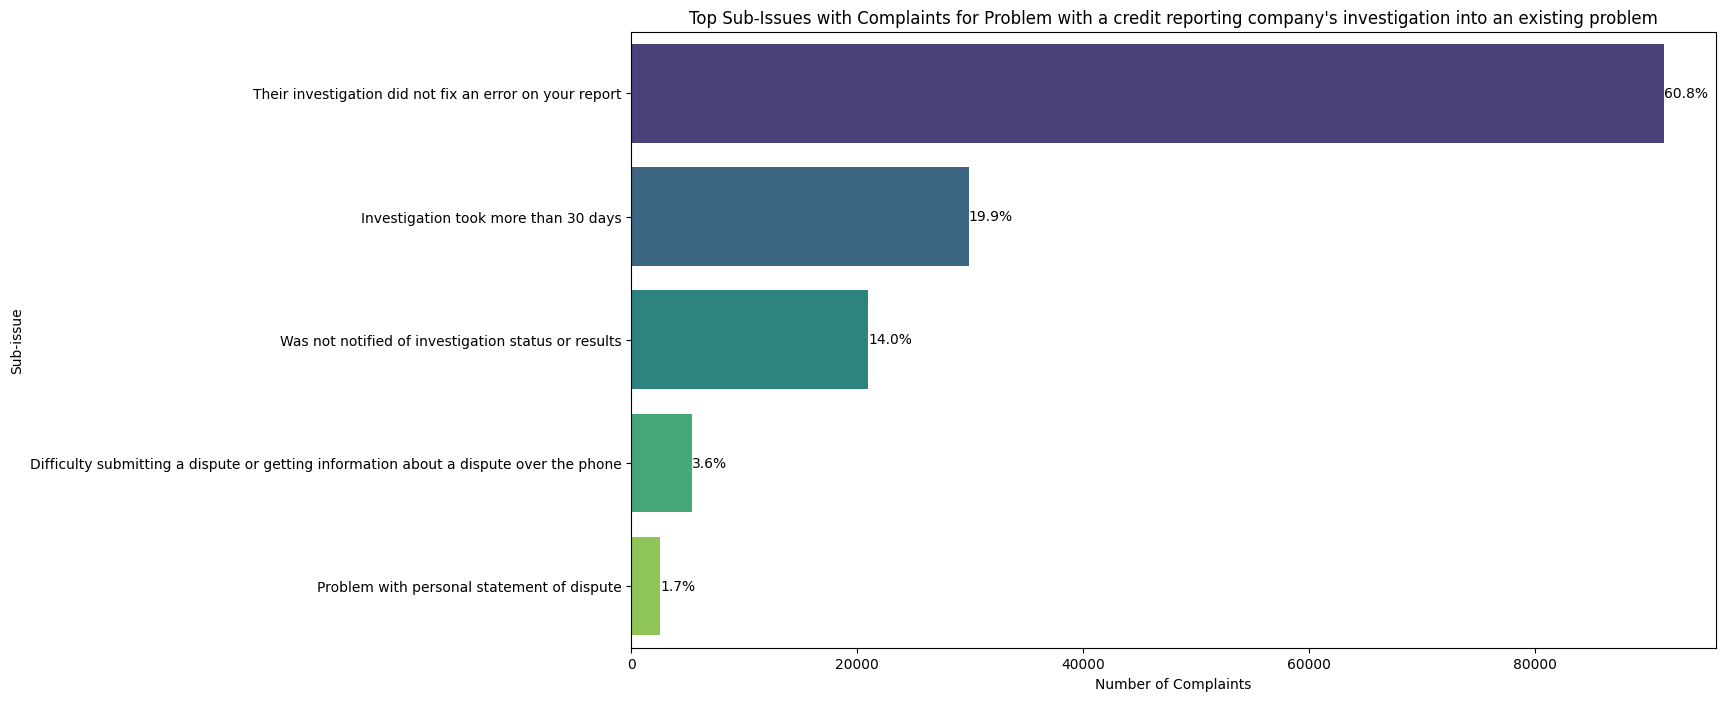

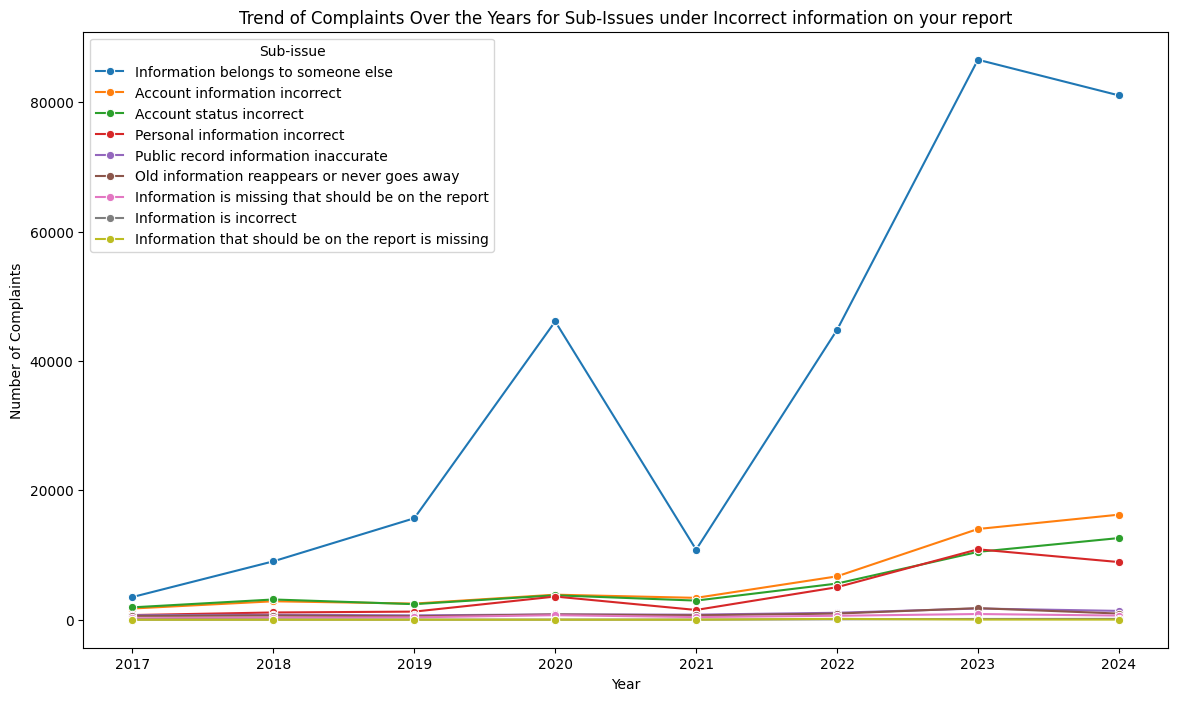

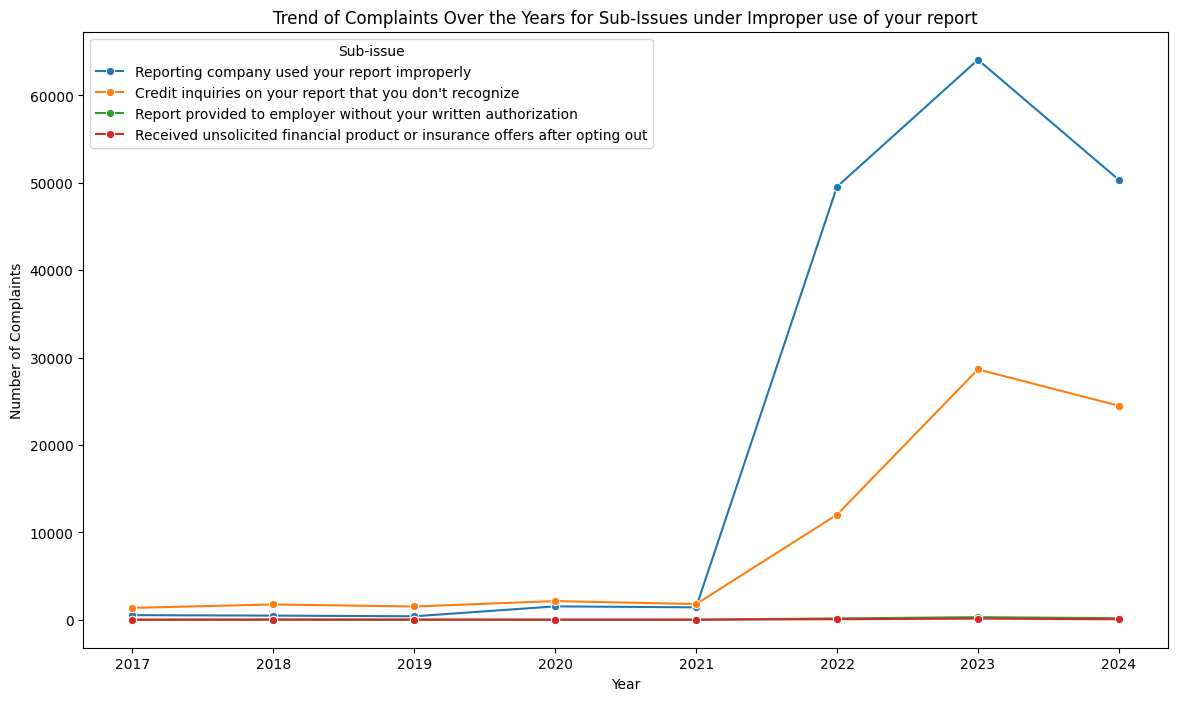

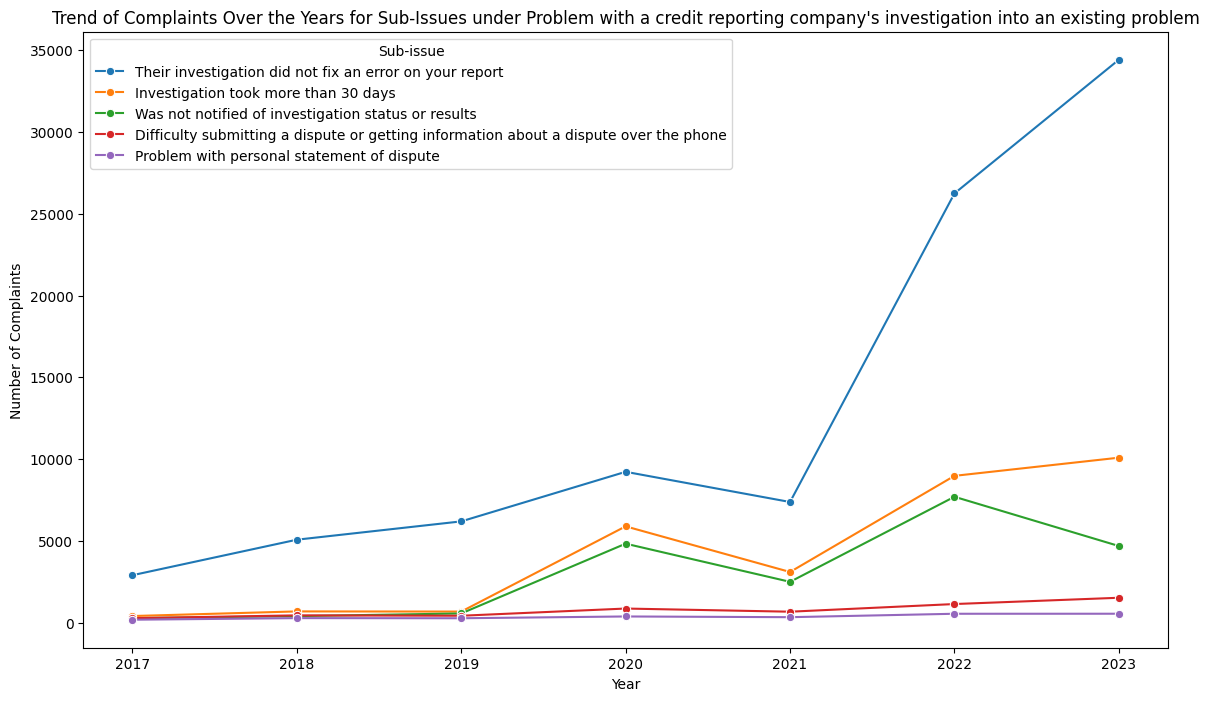

/var/folders/zr/gzwryy5s75s63h4qbx6269tc0000gn/T/ipykernel_2537/2657370172.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=timely_response_counts.index, y=timely_response_counts.values, palette='viridis')
/var/folders/zr/gzwryy5s75s63h4qbx6269tc0000gn/T/ipykernel_2537/2657370172.py:109: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percentage = timely_response_percentages[i]


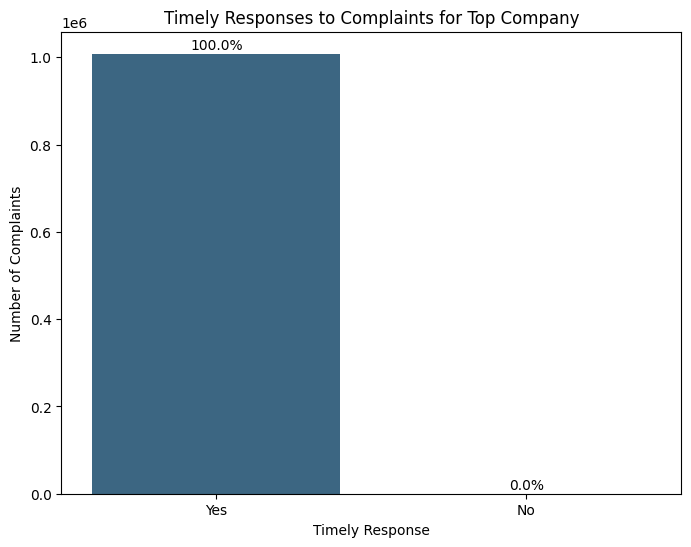

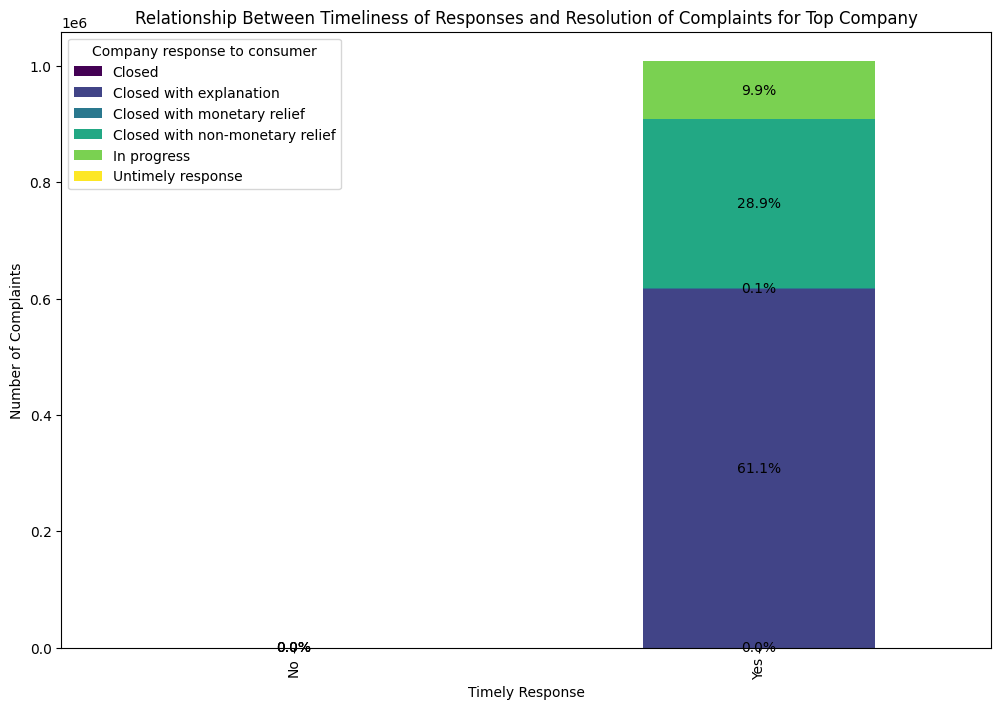

posx and posy should be finite values
posx and posy should be finite values


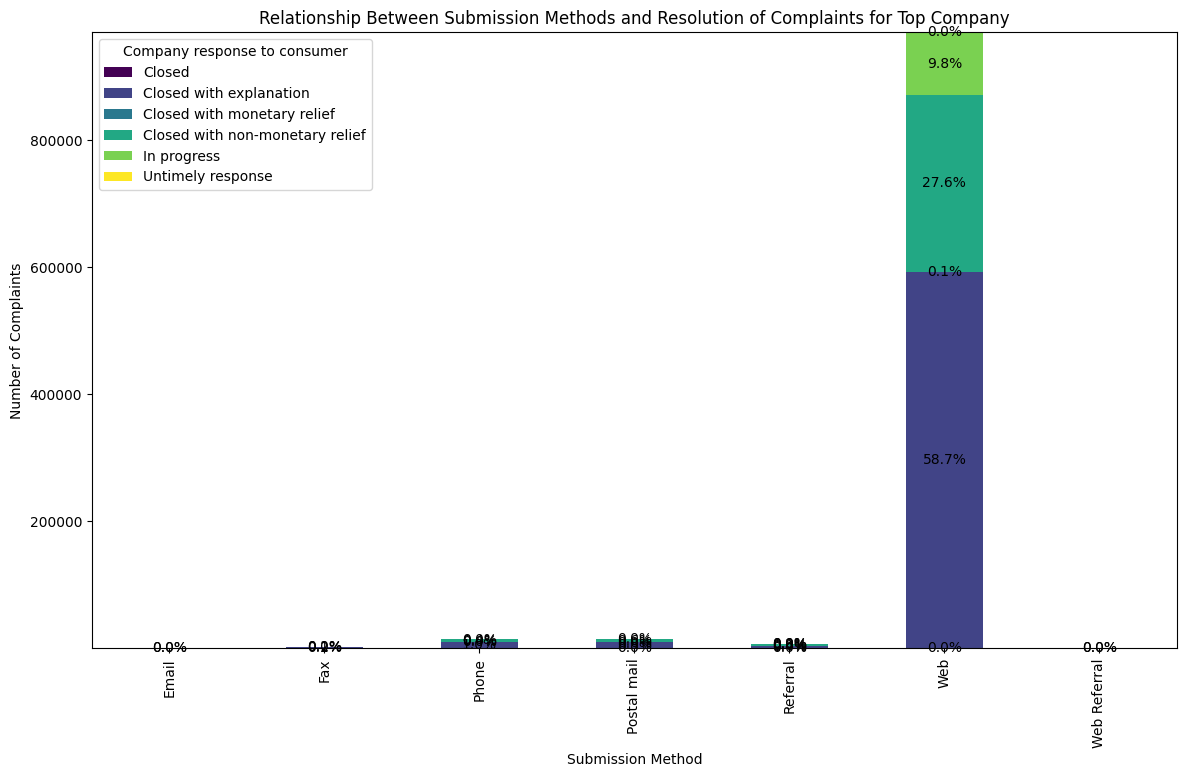

  State  Number of Complaints
0    AA                     2
1    AE                   178
2    AK                   616
3    AL                 21124
4    AP                    81


In [21]:
get_analysis(top_3_companies[2])

In [32]:
zip_data=pd.read_csv('uszips.csv')

In [33]:
zip_data.head()

zip       lat       lng       city state_id   state_name  zcta  \
0  601  18.18027 -66.75266   Adjuntas       PR  Puerto Rico  True   
1  602  18.36075 -67.17541     Aguada       PR  Puerto Rico  True   
2  603  18.45744 -67.12225  Aguadilla       PR  Puerto Rico  True   
3  606  18.16585 -66.93716    Maricao       PR  Puerto Rico  True   
4  610  18.29110 -67.12243     Anasco       PR  Puerto Rico  True   

   parent_zcta  population  density  county_fips county_name  \
0          NaN     16834.0    100.9        72001    Adjuntas   
1          NaN     37642.0    479.2        72003      Aguada   
2          NaN     49075.0    551.7        72005   Aguadilla   
3          NaN      5590.0     48.7        72093     Maricao   
4          NaN     25542.0    265.7        72011      Añasco   

                                      county_weights  \
0                    {"72001": 98.74, "72141": 1.26}   
1                                     {"72003": 100}   
2                    {"72005": 99.76, "72099": 0.24}   
3    {"72093": 82.27, "72153": 11.66, "72121": 6.06}   
4  {"72011": 96.71, "72099": 2.82, "72083": 0.37,...   

                county_names_all          county_fips_all  imprecise  \
0                Adjuntas|Utuado              72001|72141      False   
1                         Aguada                    72003      False   
2                 Aguadilla|Moca              72005|72099      False   
3    Maricao|Yauco|Sabana Grande        72093|72153|72121      False   
4  Añasco|Moca|Las Marías|Aguada  72011|72099|72083|72003      False   

   military             timezone  
0     False  America/Puerto_Rico  
1     False  America/Puerto_Rico  
2     False  America/Puerto_Rico  
3     False  America/Puerto_Rico  
4     False  America/Puerto_Rico

In [34]:
zip_data.columns

Index(['zip', 'lat', 'lng', 'city', 'state_id', 'state_name', 'zcta',
       'parent_zcta', 'population', 'density', 'county_fips', 'county_name',
       'county_weights', 'county_names_all', 'county_fips_all', 'imprecise',
       'military', 'timezone'],
      dtype='object')

In [35]:
state_to_region = {
    'Northeast': ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA'],
    'Midwest': ['IL', 'IN', 'MI', 'OH', 'WI', 'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD'],
    'South': ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'DC', 'WV', 'AL', 'KY', 'MS', 'TN', 'AR', 'LA', 'OK', 'TX'],
    'West': ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY', 'AK', 'CA', 'HI', 'OR', 'WA']
}


def map_state_to_region(state_id):
    for region, states in state_to_region.items():
        if state_id in states:
            return region
    return 'Unknown'


zip_data['Region'] = zip_data['state_id'].apply(map_state_to_region)


print(zip_data[['zip', 'state_id', 'Region']].head())

   zip state_id   Region
0  601       PR  Unknown
1  602       PR  Unknown
2  603       PR  Unknown
3  606       PR  Unknown
4  610       PR  Unknown


In [36]:
df_cleaned['ZIP code'] = df_cleaned['ZIP code'].astype(str)
zip_data['zip'] = zip_data['zip'].astype(str)


df_with_regions = pd.merge(df_cleaned, zip_data[['zip', 'Region']], left_on='ZIP code', right_on='zip', how='left')

print(df_with_regions.head())

  Date received                                            Product  \
0    2024-06-29  Credit reporting, credit repair services, or o...   
1    2024-06-29  Credit reporting, credit repair services, or o...   
2    2024-06-29  Credit reporting, credit repair services, or o...   
3    2024-06-29  Credit reporting, credit repair services, or o...   
4    2024-06-29  Credit reporting, credit repair services, or o...   

        Sub-product                                 Issue  \
0  Credit reporting           Improper use of your report   
1  Credit reporting           Improper use of your report   
2  Credit reporting           Improper use of your report   
3  Credit reporting  Incorrect information on your report   
4  Credit reporting  Incorrect information on your report   

                                           Sub-issue  \
0      Reporting company used your report improperly   
1      Reporting company used your report improperly   
2  Credit inquiries on your report that you 

In [37]:

df_with_regions_filtered = df_with_regions[df_with_regions['Region'] != 'Unknown']


print(df_with_regions_filtered.head())


  Date received                                            Product  \
0    2024-06-29  Credit reporting, credit repair services, or o...   
1    2024-06-29  Credit reporting, credit repair services, or o...   
2    2024-06-29  Credit reporting, credit repair services, or o...   
3    2024-06-29  Credit reporting, credit repair services, or o...   
4    2024-06-29  Credit reporting, credit repair services, or o...   

        Sub-product                                 Issue  \
0  Credit reporting           Improper use of your report   
1  Credit reporting           Improper use of your report   
2  Credit reporting           Improper use of your report   
3  Credit reporting  Incorrect information on your report   
4  Credit reporting  Incorrect information on your report   

                                           Sub-issue  \
0      Reporting company used your report improperly   
1      Reporting company used your report improperly   
2  Credit inquiries on your report that you 

In [38]:

complaints_by_region_filtered = df_with_regions_filtered.groupby('Region').size().reset_index(name='Number of Complaints')

print(complaints_by_region_filtered)


      Region  Number of Complaints
0    Midwest                671061
1  Northeast                555618
2      South               2417090
3       West                933372


In [42]:

response_counts_by_region = df_with_regions_filtered.groupby('Region')['Timely response?'].value_counts(normalize=True).unstack().fillna(0)


response_percentages_by_region = response_counts_by_region * 100

print("\nPercentage of Timely Responses by Region:")
print(response_percentages_by_region)



Percentage of Timely Responses by Region:
Timely response?        No        Yes
Region                               
Midwest           1.045360  98.954640
Northeast         0.756095  99.243905
South             0.939146  99.060854
West              1.369336  98.630664


In [51]:
top_companies = df_with_regions_filtered['Company'].value_counts().head(3).index.tolist()
top_companies_data = df_with_regions_filtered[df_with_regions_filtered['Company'].isin(top_companies)]


complaints_by_company_region = top_companies_data.groupby(['Company', 'Region']).size().reset_index(name='Total Number of Complaints')


complaints_matrix = complaints_by_company_region.pivot(index='Region', columns='Company', values='Total Number of Complaints')


print("Complaints Matrix (Regions as Rows, Companies as Columns):")
print(complaints_matrix)


Complaints Matrix (Regions as Rows, Companies as Columns):
Company    EQUIFAX, INC.  Experian Information Solutions Inc.  \
Region                                                          
Midwest           133814                               117791   
Northeast         125863                               107782   
South             584146                               482925   
West              167423                               150418   

Company    TRANSUNION INTERMEDIATE HOLDINGS, INC.  
Region                                             
Midwest                                    132341  
Northeast                                  119209  
South                                      529769  
West                                       161431  
